In [141]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import geopy.distance

import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

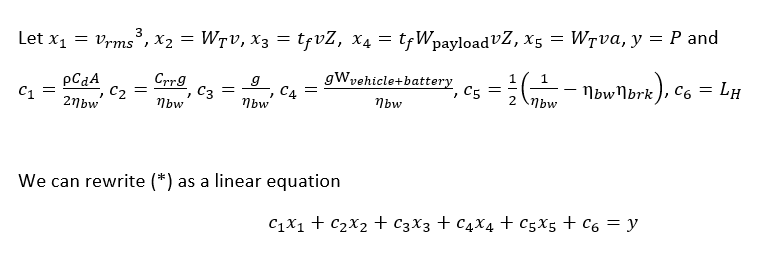

In [142]:
data = pd.read_csv("data_husky.csv", low_memory=False)
data = data[data.test != 102]

In [143]:
data['x1'] = data.V**3
data['x2'] = data.V
data['x3'] = data.V*data.Z
data['x4'] = data.V*data.a
data['y'] = data.power


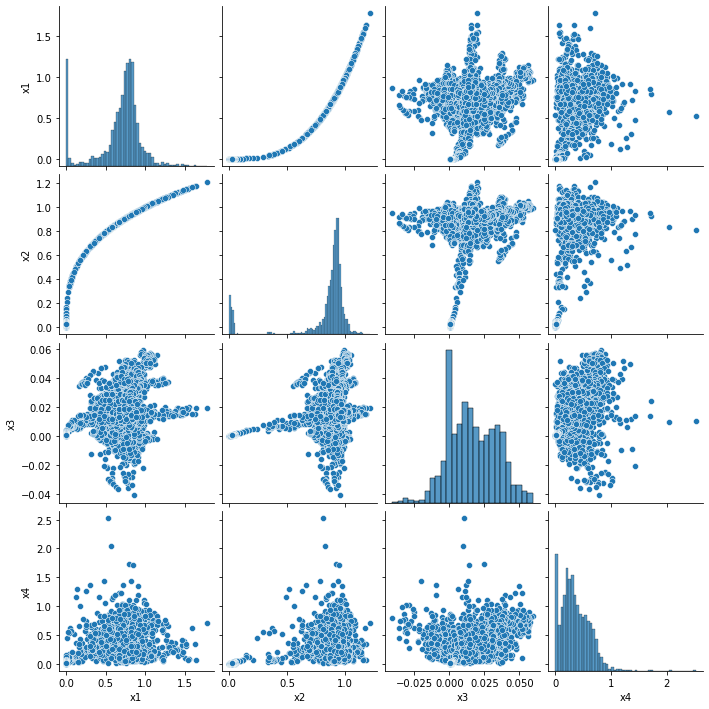

In [144]:
df = data[data.test==1].copy()
df = df.loc[:, ['x1','x2','x3','x4']].copy()

sns.pairplot(df)
plt.show()

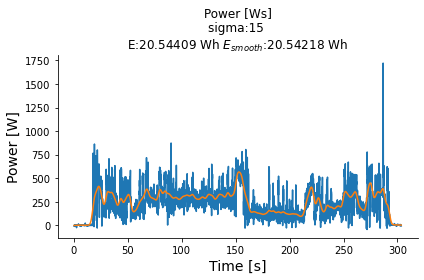

In [145]:
df = data[data.test==1].copy()

sigma=15
df['power_smooth'] = scipy.ndimage.filters.gaussian_filter(df.power,sigma)

E_real = scipy.integrate.simps(df['power'], x=df["time"], even="avg") / 3600
E_smooth = scipy.integrate.simps(df['power_smooth'], x=df["time"], even="avg") / 3600

plt.plot(df.time, df.power)
plt.plot(df.time, df.power_smooth, label=sigma)
plt.title("Power [Ws]\nsigma:%d \nE:%.5f Wh $E_{smooth}$:%.5f Wh"%(sigma, E_real, E_smooth))
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Power [W]", fontsize=14)
sns.despine(top=True, right=True)
plt.show()

In [146]:
X = df[['x1','x2','x3','x4',]]
Y = df['y']
X = sm.add_constant(X)

mod = sm.OLS(Y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     616.6
Date:                Mon, 11 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:36:54   Log-Likelihood:                -18957.
No. Observations:                3030   AIC:                         3.792e+04
Df Residuals:                    3025   BIC:                         3.795e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9603      7.768     -0.639      0.5

C:\Users\thiag\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [147]:
X = df[['x1','x2','x3','x4',]]
Y = df['power_smooth']
X = sm.add_constant(X)

mod = sm.OLS(Y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           power_smooth   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1077.
Date:                Mon, 11 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:36:54   Log-Likelihood:                -17375.
No. Observations:                3030   AIC:                         3.476e+04
Df Residuals:                    3025   BIC:                         3.479e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4689      4.609      2.054      0.0

C:\Users\thiag\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


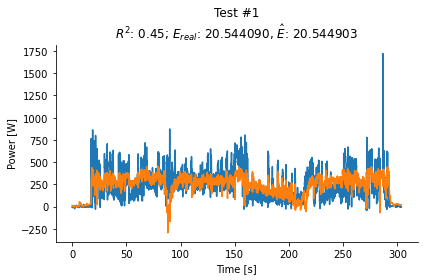

c1: -819.46
c2: 1107.44
c3: -1682.42
c4: -201.81
c5: -4.96


In [148]:
DF = data.copy()
#DF = DF[DF.route=='C']
DF = DF[DF.test==1]

X = DF[['x1','x2','x3','x4',]]
Y = DF['y']
tests = list(set(DF.test))
reg = LinearRegression().fit(X,Y)
DF['P_hat'] = reg.predict(X)

e_real = []
e_hat = []
route = []



for test in tests: 
    df = DF[DF.test==test]
    E_real = scipy.integrate.simps(df['power'], x=df["time"], even="avg") / 3600
    E_hat = scipy.integrate.simps(df['P_hat'], x=df["time"], even="avg") / 3600
    e_real.append(E_real)
    e_hat.append(E_hat)
    route.append(list(set(df.route))[0])
    plt.plot(df.time, df.power)
    plt.plot(df.time, df.P_hat)
    plt.title("Test #%d\n$R^{2}$: %.2f; $E_{real}$: %f, $\hat{E}$: %f"%(test,reg.score(X,Y), E_real, E_hat))
    sns.despine(top=True, right=True)
    plt.ylabel("Power [W]")
    plt.xlabel("Time [s]")
    plt.show()
    #a = 1/0
    cs = ['c1','c2','c3','c4', 'c5']
    coefs = list(reg.coef_)
    coefs.append(reg.intercept_)
    for i in range(len(coefs)):
        print("%s: %.2f"%(cs[i],coefs[i]))

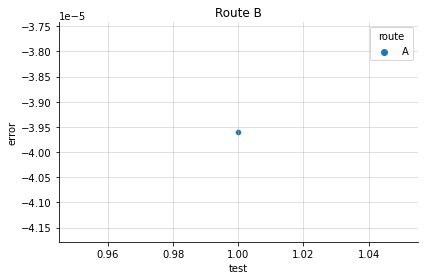

In [149]:
summary = pd.DataFrame({"test":tests, "E_real":e_real, "E_hat":e_hat, 'route':route})
summary['error'] = (summary.E_real - summary.E_hat)/summary.E_real
sns.scatterplot(x="test", y="error", data = summary, hue='route')

sns.despine(top=True, right=True)
#plt.xlim(0,38)
plt.grid(visible=True, which='major', alpha=0.5)
plt.title("Route B")
plt.show()

In [150]:
print(np.fabs(summary.error).mean())
print()

3.960242796946556e-05



In [151]:
data.columns


Index(['test', 'time', 'battery_voltage_computer', 'battery_current_computer',
       'battery_voltage_husky', 'battery_current_husky', 'position_x',
       'position_y', 'position_z', 'orientation_x', 'orientation_y',
       'orientation_z', 'orientation_w', 'twist_linear_x', 'twist_linear_y',
       'twist_linear_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'temperature', 'humidity', 'route', 'speed',
       'payload', 'roll_x', 'pitch_y', 'yaw_z', 'power', 'a', 'a_total', 'V',
       'Z', 'tf', 'x1', 'x2', 'x3', 'x4', 'y'],
      dtype='object')

In [152]:
data['current'] = data.battery_current_husky.copy()
data['voltage'] = data.battery_voltage_husky.copy()
data['vx'] = data.twist_linear_x.copy()
data['vy'] = data.twist_linear_y.copy()
data['vz'] = data.twist_linear_z.copy()
data['pitch'] = data.pitch_y.copy()
data['ax'] = data.linear_acceleration_x.copy()
data['ay'] = data.linear_acceleration_y.copy()
data['az'] = data.linear_acceleration_z.copy()

#data['velocity'] = (data.twist_linear_y**2 + data.twist_linear_x**2 + data.twist_linear_z**2)**0.5

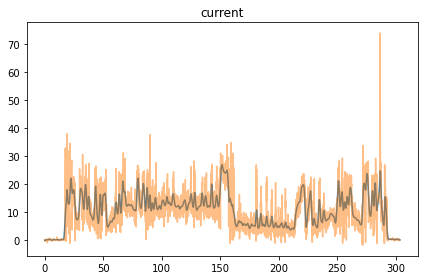

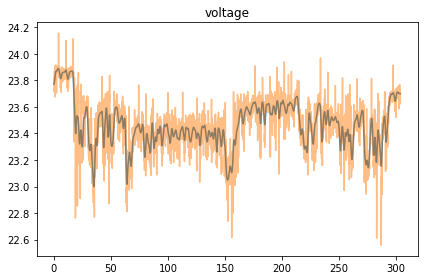

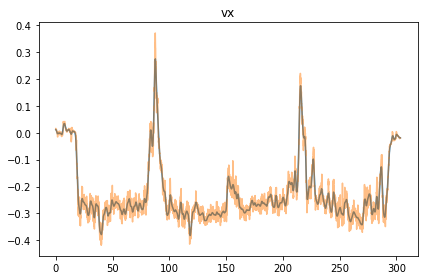

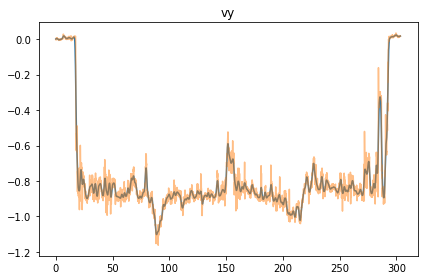

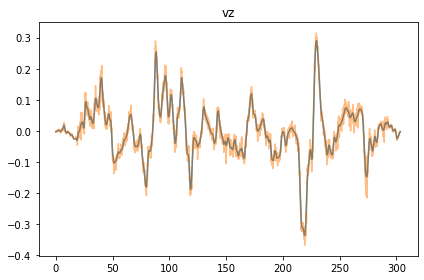

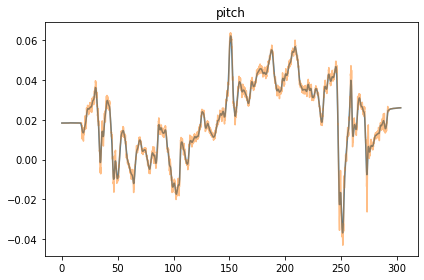

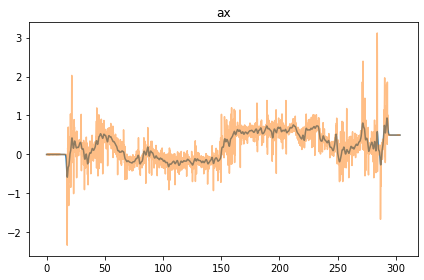

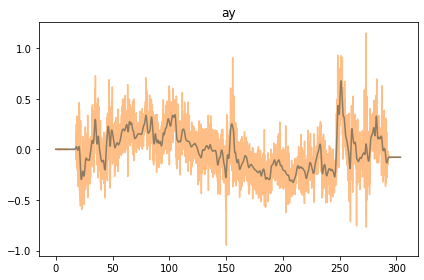

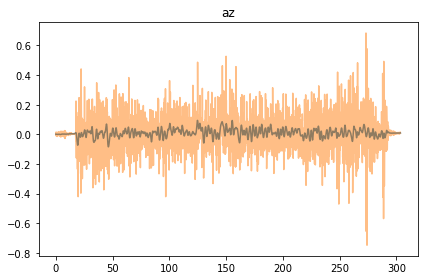

In [153]:
originals = ['battery_current_husky', 'battery_voltage_husky', "twist_linear_x", 'twist_linear_y', 
             'twist_linear_z', 'pitch_y', 'linear_acceleration_x', 'linear_acceleration_y',
             'linear_acceleration_z']
variables = ['current','voltage','vx', 'vy', 'vz', 'pitch','ax', 'ay', 'az']
sigma = 5
for var in variables:
    for test in tests:
        df = data.loc[data.test == test].copy()
        data.loc[data.test == test,var] = scipy.ndimage.filters.gaussian_filter(df.loc[:,var],sigma)

for i in range(len(variables)):
    for test in [1]:
        df = data.loc[data.test == test].copy()
        plt.plot(df.time,df[variables[i]])
        plt.plot(df.time,df[originals[i]], alpha=0.5)
        plt.title(variables[i])
        plt.show()

In [154]:
data['p'] = data.current*data.voltage
data['v'] = (data.vy**2 + data.vx**2 + data.vz**2)**0.5
data['z'] = np.tan(data.pitch)
data['a'] = (data.linear_acceleration_y**2 + data.linear_acceleration_x**2)**0.5

In [155]:
data['x1'] = data.v**3
data['x2'] = data.payload*data.v
data['x3'] = data.v*data.z
data['x4'] = data.payload*data.v*data.z
data['x5'] = data.payload*data.v*data.a
data['y'] = data.p

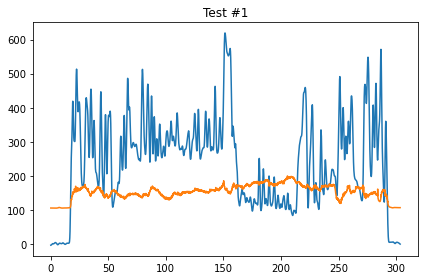

$R^{2}$: 0.02; $E_{real}$: 20.572344, $$\hat{E}$$: 12.983766
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


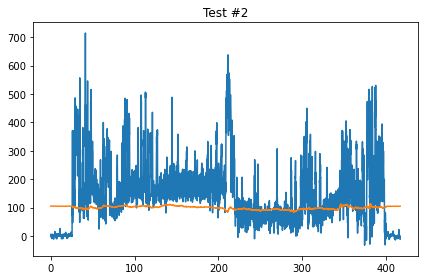

$R^{2}$: 0.02; $E_{real}$: 17.094953, $$\hat{E}$$: 11.572458
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


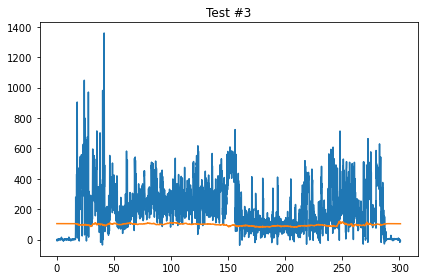

$R^{2}$: 0.02; $E_{real}$: 17.199034, $$\hat{E}$$: 8.208796
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


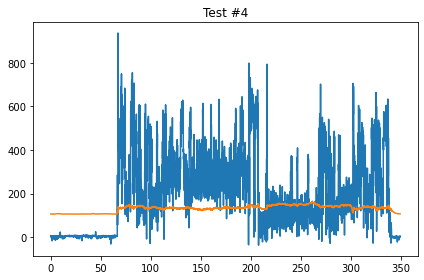

$R^{2}$: 0.02; $E_{real}$: 19.699547, $$\hat{E}$$: 12.703087
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


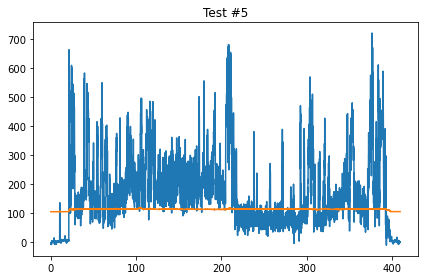

$R^{2}$: 0.02; $E_{real}$: 19.608597, $$\hat{E}$$: 12.943931
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


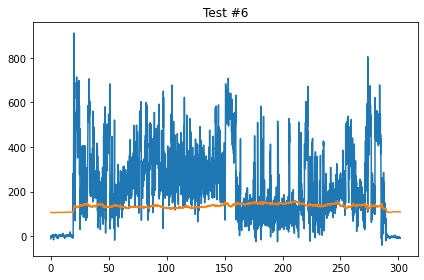

$R^{2}$: 0.02; $E_{real}$: 19.085043, $$\hat{E}$$: 11.233473
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


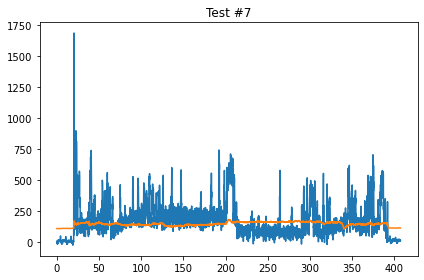

$R^{2}$: 0.02; $E_{real}$: 19.775792, $$\hat{E}$$: 16.213748
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


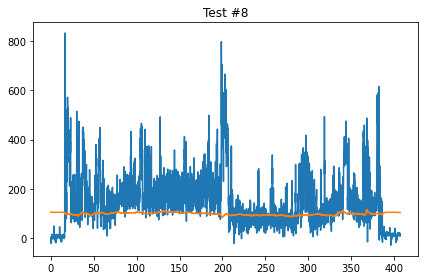

$R^{2}$: 0.02; $E_{real}$: 17.702494, $$\hat{E}$$: 11.176865
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


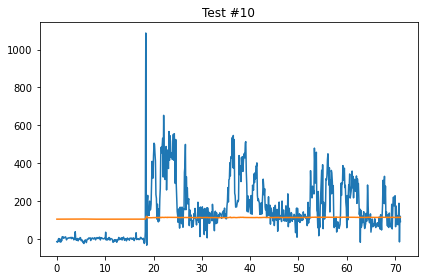

$R^{2}$: 0.02; $E_{real}$: 2.954703, $$\hat{E}$$: 2.216986
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


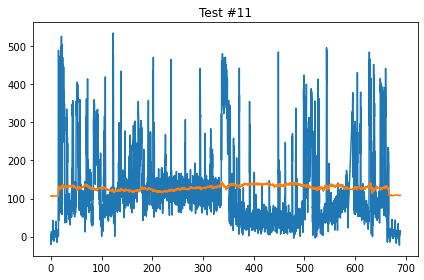

$R^{2}$: 0.02; $E_{real}$: 23.083939, $$\hat{E}$$: 24.442310
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


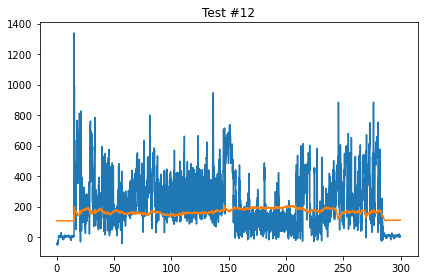

$R^{2}$: 0.02; $E_{real}$: 19.506273, $$\hat{E}$$: 13.576143
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


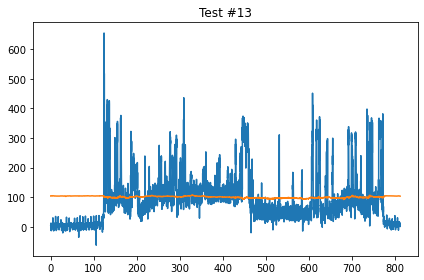

$R^{2}$: 0.02; $E_{real}$: 21.010937, $$\hat{E}$$: 22.791911
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


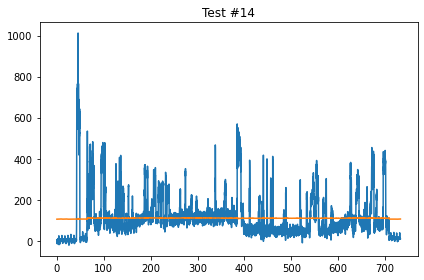

$R^{2}$: 0.02; $E_{real}$: 23.333217, $$\hat{E}$$: 22.378894
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


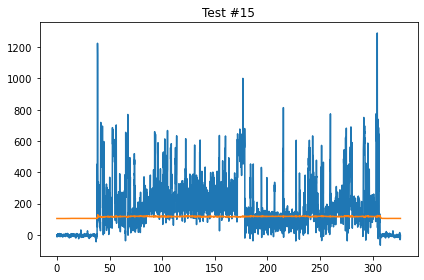

$R^{2}$: 0.02; $E_{real}$: 16.152550, $$\hat{E}$$: 10.525700
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


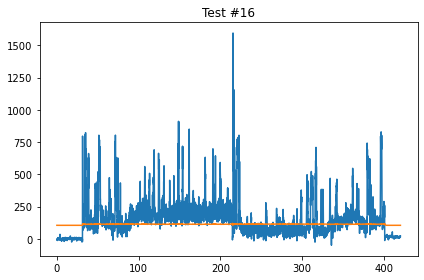

$R^{2}$: 0.02; $E_{real}$: 18.899624, $$\hat{E}$$: 13.242237
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


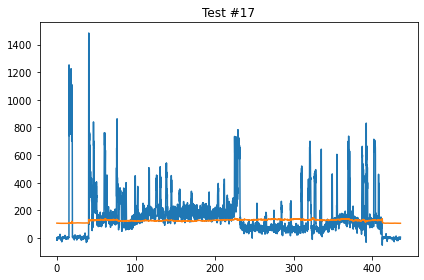

$R^{2}$: 0.02; $E_{real}$: 18.853644, $$\hat{E}$$: 15.208335
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


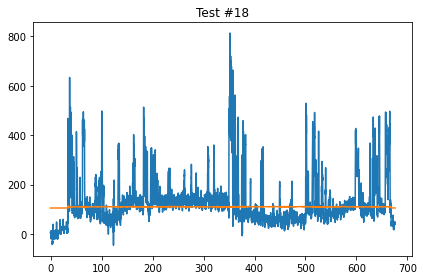

$R^{2}$: 0.02; $E_{real}$: 24.604352, $$\hat{E}$$: 20.697738
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


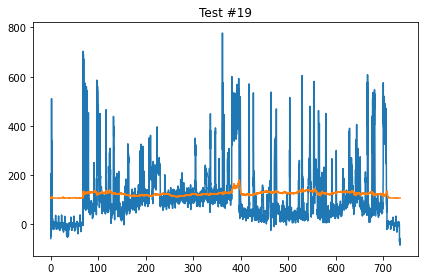

$R^{2}$: 0.02; $E_{real}$: 22.395024, $$\hat{E}$$: 25.292736
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


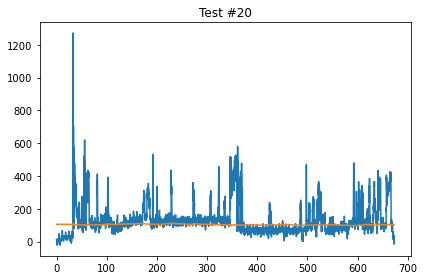

$R^{2}$: 0.02; $E_{real}$: 24.051927, $$\hat{E}$$: 19.286544
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


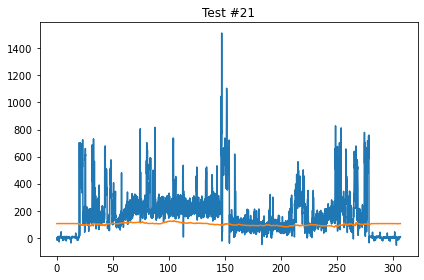

$R^{2}$: 0.02; $E_{real}$: 15.926105, $$\hat{E}$$: 8.565462
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


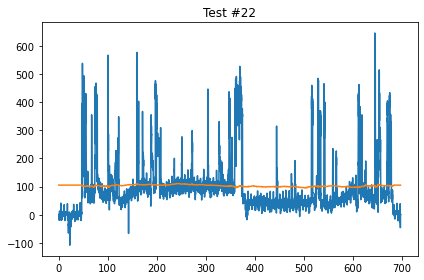

$R^{2}$: 0.02; $E_{real}$: 18.679556, $$\hat{E}$$: 19.969156
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


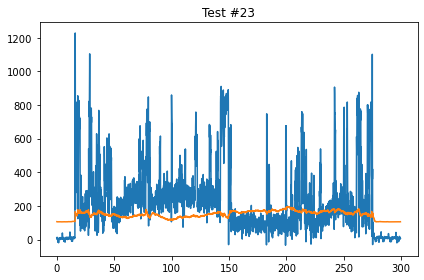

$R^{2}$: 0.02; $E_{real}$: 18.709396, $$\hat{E}$$: 12.350833
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


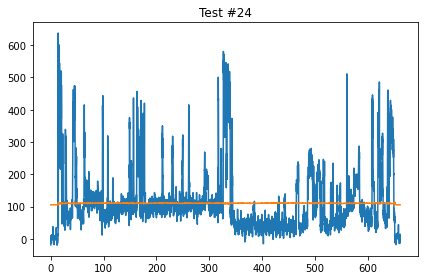

$R^{2}$: 0.02; $E_{real}$: 20.775206, $$\hat{E}$$: 20.263406
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


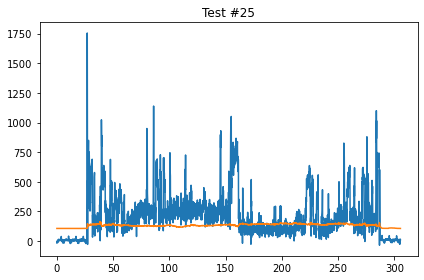

$R^{2}$: 0.02; $E_{real}$: 18.141401, $$\hat{E}$$: 11.168183
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


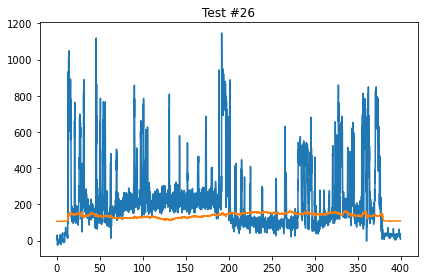

$R^{2}$: 0.02; $E_{real}$: 24.447680, $$\hat{E}$$: 15.282672
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


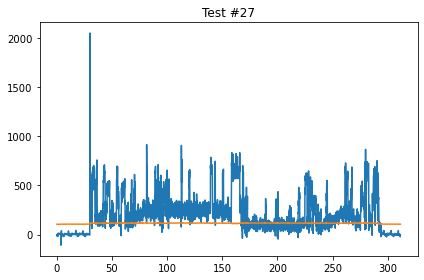

$R^{2}$: 0.02; $E_{real}$: 18.647726, $$\hat{E}$$: 9.985010
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


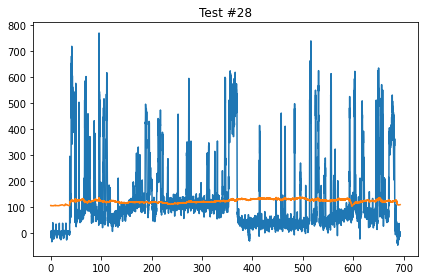

$R^{2}$: 0.02; $E_{real}$: 24.522703, $$\hat{E}$$: 23.785722
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


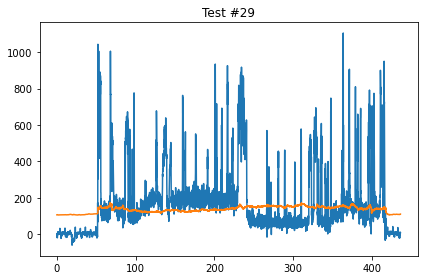

$R^{2}$: 0.02; $E_{real}$: 21.281099, $$\hat{E}$$: 16.573529
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


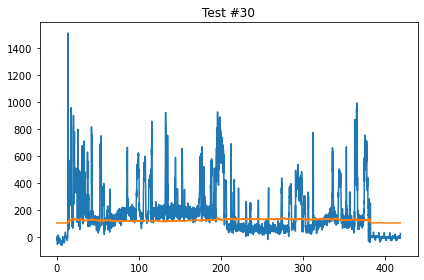

$R^{2}$: 0.02; $E_{real}$: 20.909856, $$\hat{E}$$: 14.659815
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


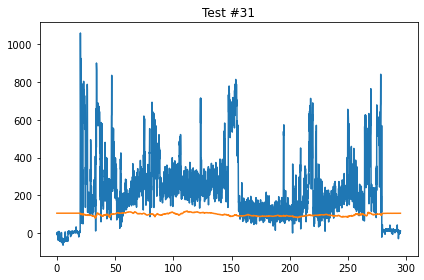

$R^{2}$: 0.02; $E_{real}$: 18.409454, $$\hat{E}$$: 8.062426
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


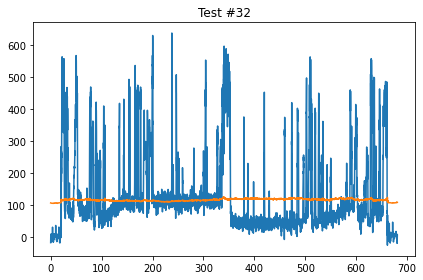

$R^{2}$: 0.02; $E_{real}$: 24.258703, $$\hat{E}$$: 21.988789
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


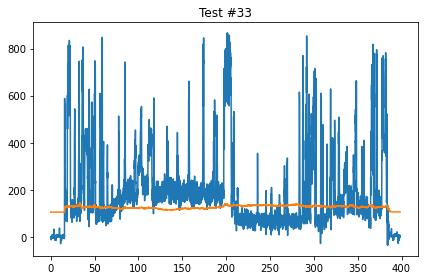

$R^{2}$: 0.02; $E_{real}$: 21.334857, $$\hat{E}$$: 13.951532
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


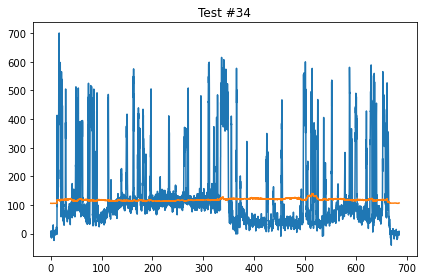

$R^{2}$: 0.02; $E_{real}$: 24.752222, $$\hat{E}$$: 22.464702
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


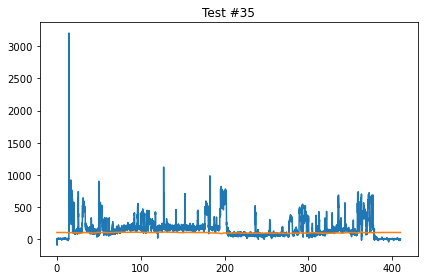

$R^{2}$: 0.02; $E_{real}$: 19.570952, $$\hat{E}$$: 11.468438
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


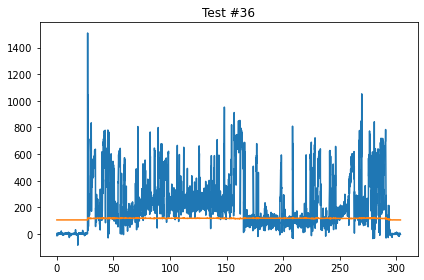

$R^{2}$: 0.02; $E_{real}$: 19.457628, $$\hat{E}$$: 9.810368
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


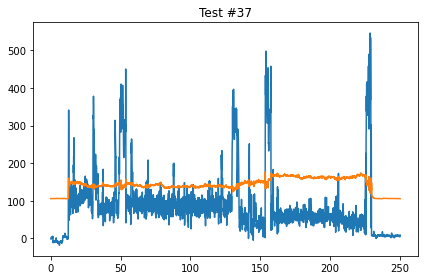

$R^{2}$: 0.02; $E_{real}$: 6.073700, $$\hat{E}$$: 9.930253
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


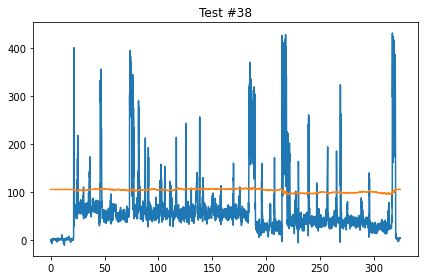

$R^{2}$: 0.02; $E_{real}$: 5.567763, $$\hat{E}$$: 9.305642
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


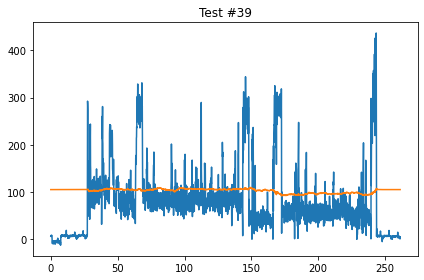

$R^{2}$: 0.02; $E_{real}$: 5.869606, $$\hat{E}$$: 7.470465
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


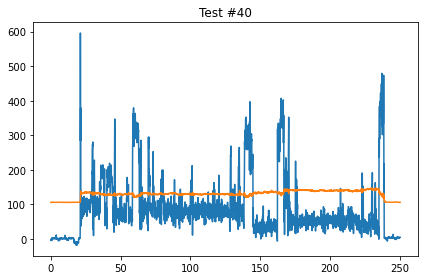

$R^{2}$: 0.02; $E_{real}$: 6.090849, $$\hat{E}$$: 9.011762
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


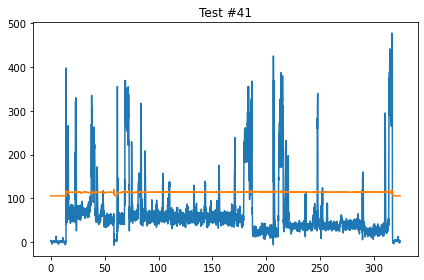

$R^{2}$: 0.02; $E_{real}$: 5.985561, $$\hat{E}$$: 10.227509
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


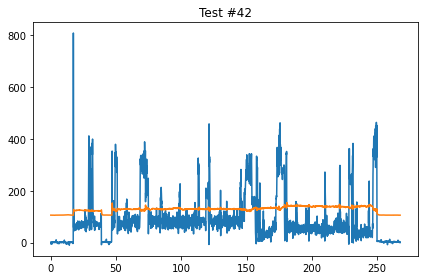

$R^{2}$: 0.02; $E_{real}$: 6.568338, $$\hat{E}$$: 9.507502
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


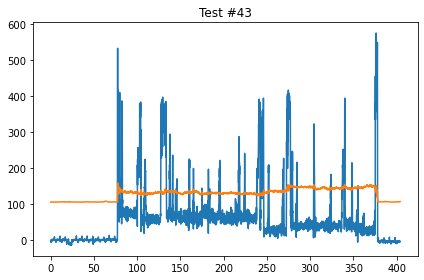

$R^{2}$: 0.02; $E_{real}$: 7.059728, $$\hat{E}$$: 14.446866
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


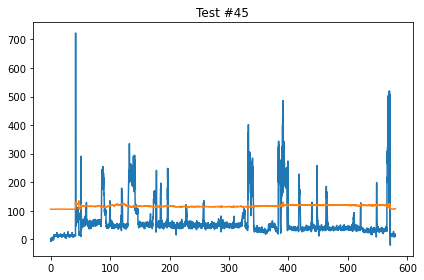

$R^{2}$: 0.02; $E_{real}$: 9.895926, $$\hat{E}$$: 18.705109
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


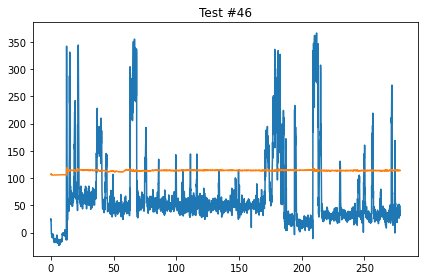

$R^{2}$: 0.02; $E_{real}$: 5.091471, $$\hat{E}$$: 8.783543
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


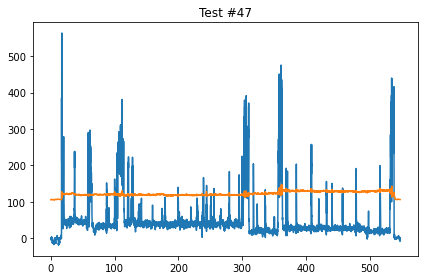

$R^{2}$: 0.02; $E_{real}$: 7.532468, $$\hat{E}$$: 18.602139
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


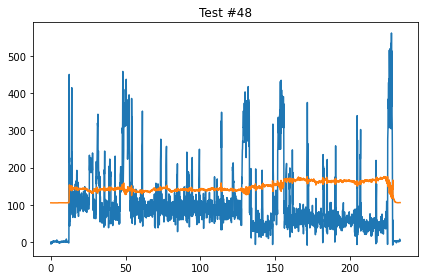

$R^{2}$: 0.02; $E_{real}$: 6.531188, $$\hat{E}$$: 9.496012
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


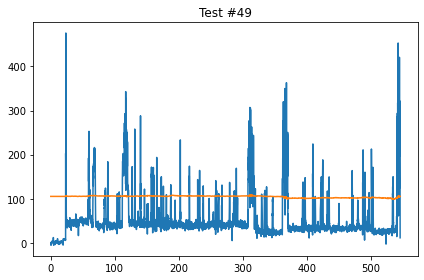

$R^{2}$: 0.02; $E_{real}$: 8.093173, $$\hat{E}$$: 15.864835
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


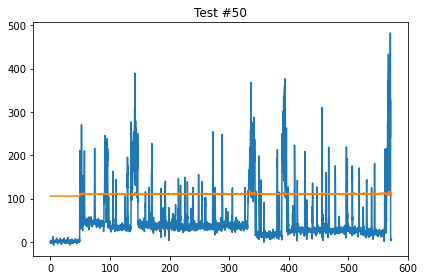

$R^{2}$: 0.02; $E_{real}$: 7.690763, $$\hat{E}$$: 17.503355
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


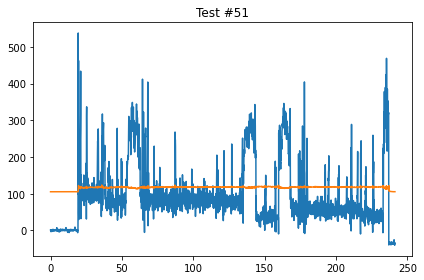

$R^{2}$: 0.02; $E_{real}$: 6.430368, $$\hat{E}$$: 7.821052
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


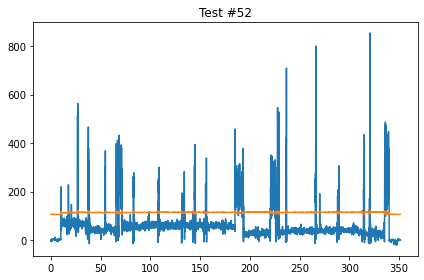

$R^{2}$: 0.02; $E_{real}$: 6.017441, $$\hat{E}$$: 11.045546
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


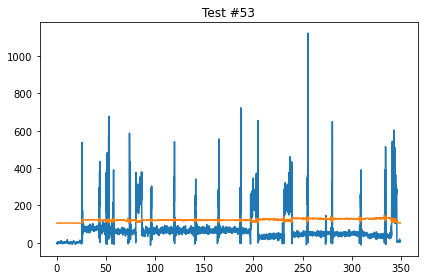

$R^{2}$: 0.02; $E_{real}$: 7.072802, $$\hat{E}$$: 11.870258
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


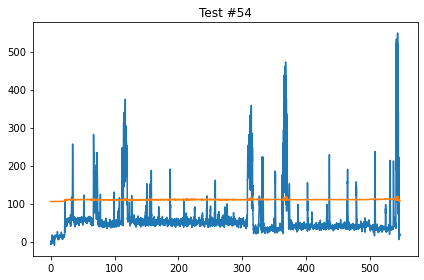

$R^{2}$: 0.02; $E_{real}$: 9.016777, $$\hat{E}$$: 16.799963
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


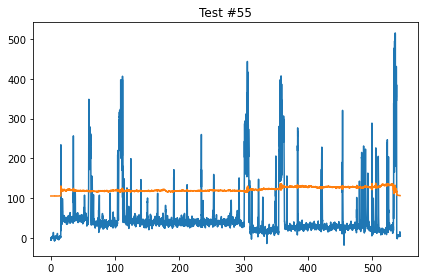

$R^{2}$: 0.02; $E_{real}$: 7.882787, $$\hat{E}$$: 18.388233
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


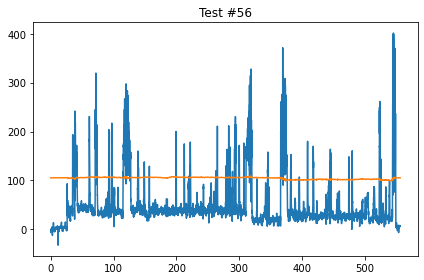

$R^{2}$: 0.02; $E_{real}$: 7.771510, $$\hat{E}$$: 16.167833
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


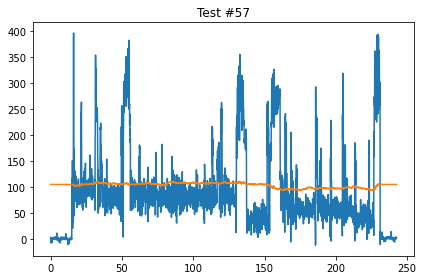

$R^{2}$: 0.02; $E_{real}$: 6.090144, $$\hat{E}$$: 6.997527
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


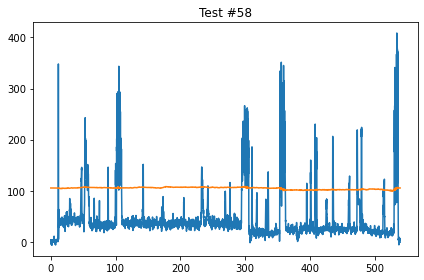

$R^{2}$: 0.02; $E_{real}$: 6.827761, $$\hat{E}$$: 15.686735
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


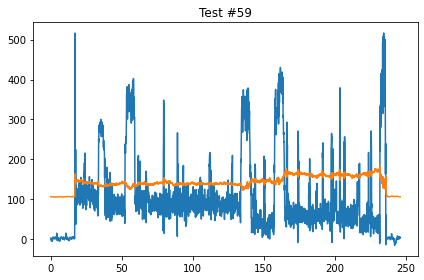

$R^{2}$: 0.02; $E_{real}$: 7.074023, $$\hat{E}$$: 9.714020
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


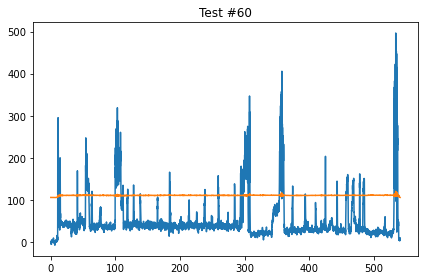

$R^{2}$: 0.02; $E_{real}$: 7.662013, $$\hat{E}$$: 16.595536
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


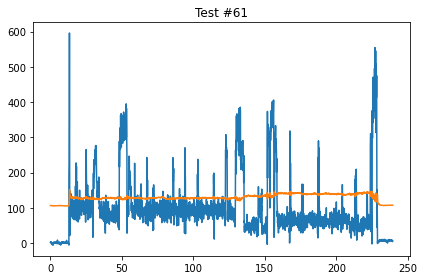

$R^{2}$: 0.02; $E_{real}$: 6.683047, $$\hat{E}$$: 8.614644
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


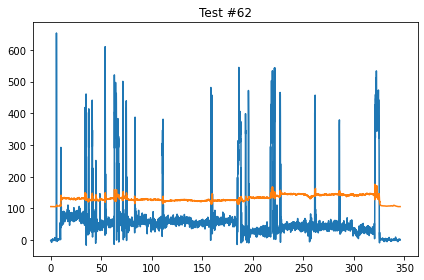

$R^{2}$: 0.02; $E_{real}$: 6.389784, $$\hat{E}$$: 12.594988
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


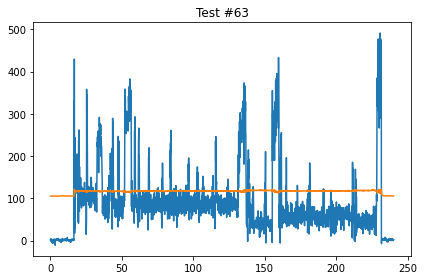

$R^{2}$: 0.02; $E_{real}$: 6.159482, $$\hat{E}$$: 7.762989
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


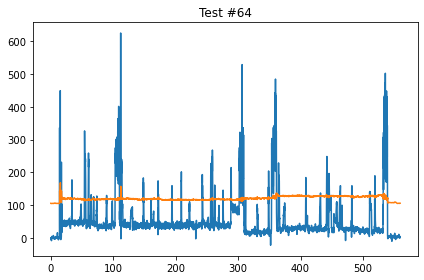

$R^{2}$: 0.02; $E_{real}$: 8.476586, $$\hat{E}$$: 18.803588
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


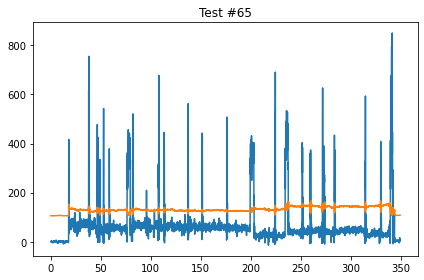

$R^{2}$: 0.02; $E_{real}$: 6.384411, $$\hat{E}$$: 12.744837
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


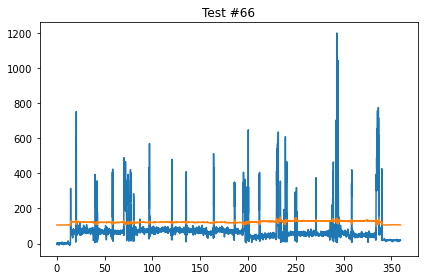

$R^{2}$: 0.02; $E_{real}$: 7.545256, $$\hat{E}$$: 12.176160
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


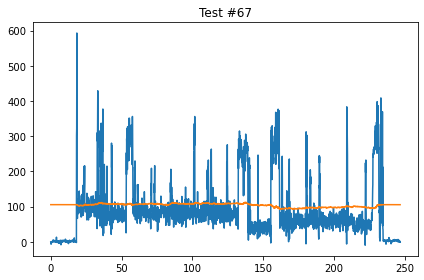

$R^{2}$: 0.02; $E_{real}$: 6.201994, $$\hat{E}$$: 7.115553
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


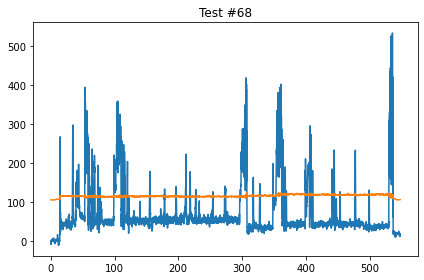

$R^{2}$: 0.02; $E_{real}$: 10.703779, $$\hat{E}$$: 17.666593
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


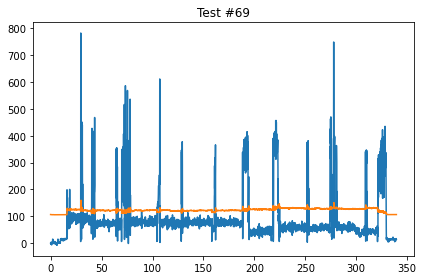

$R^{2}$: 0.02; $E_{real}$: 8.294021, $$\hat{E}$$: 11.577637
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


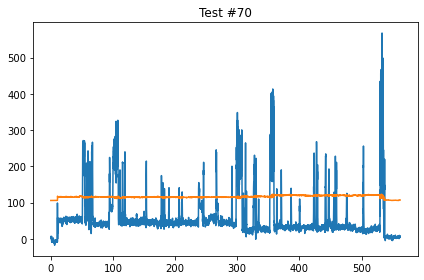

$R^{2}$: 0.02; $E_{real}$: 9.150241, $$\hat{E}$$: 18.098602
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


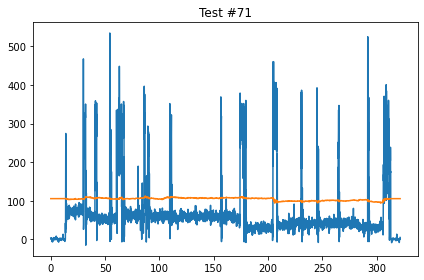

$R^{2}$: 0.02; $E_{real}$: 6.170370, $$\hat{E}$$: 9.299431
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


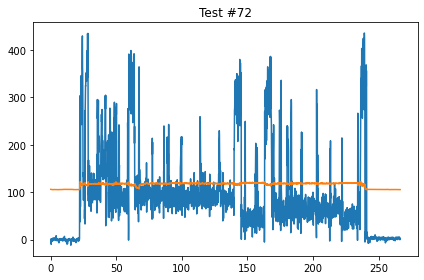

$R^{2}$: 0.02; $E_{real}$: 7.041267, $$\hat{E}$$: 8.574332
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


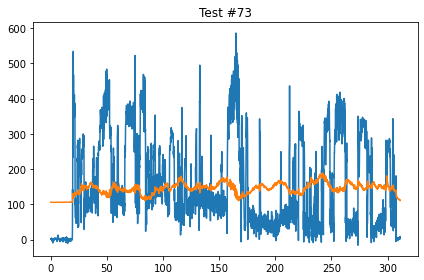

$R^{2}$: 0.02; $E_{real}$: 13.360703, $$\hat{E}$$: 12.410808
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


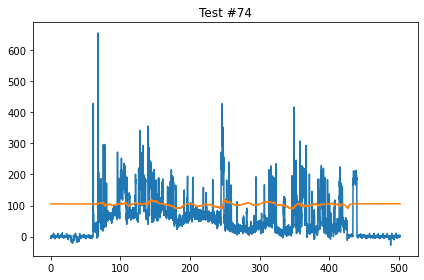

$R^{2}$: 0.02; $E_{real}$: 7.745824, $$\hat{E}$$: 14.467729
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


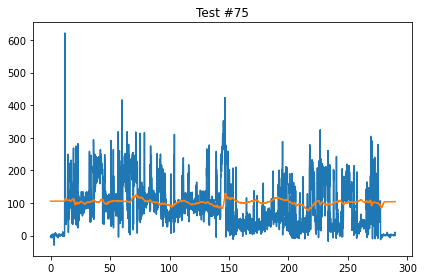

$R^{2}$: 0.02; $E_{real}$: 7.556098, $$\hat{E}$$: 8.263930
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


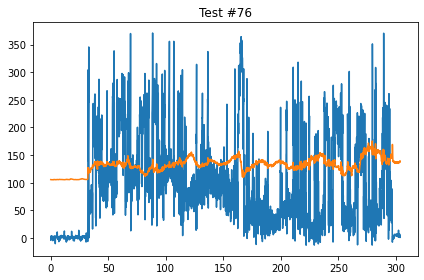

$R^{2}$: 0.02; $E_{real}$: 8.271469, $$\hat{E}$$: 11.101048
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


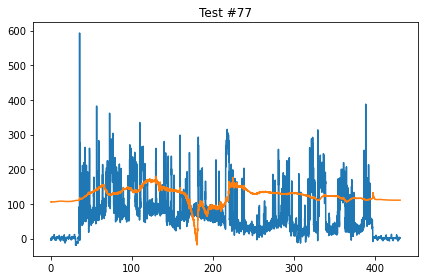

$R^{2}$: 0.02; $E_{real}$: 8.555648, $$\hat{E}$$: 14.734368
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


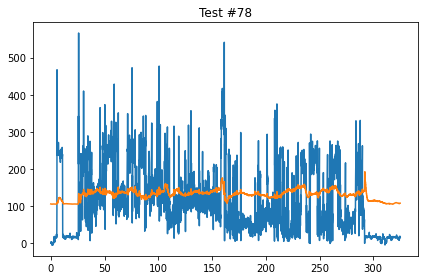

$R^{2}$: 0.02; $E_{real}$: 10.206607, $$\hat{E}$$: 11.833697
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


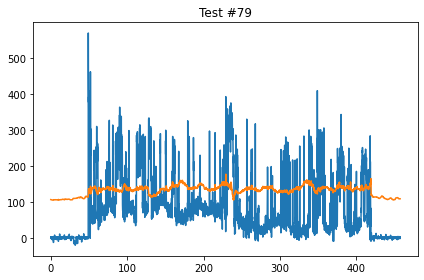

$R^{2}$: 0.02; $E_{real}$: 10.474824, $$\hat{E}$$: 16.797256
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


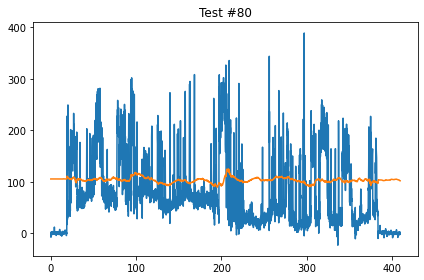

$R^{2}$: 0.02; $E_{real}$: 8.808575, $$\hat{E}$$: 11.763226
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


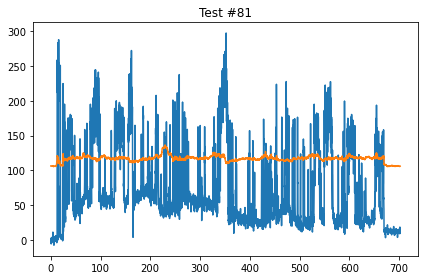

$R^{2}$: 0.02; $E_{real}$: 14.101724, $$\hat{E}$$: 22.817446
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


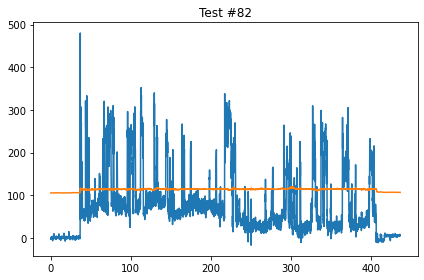

$R^{2}$: 0.02; $E_{real}$: 8.922415, $$\hat{E}$$: 13.715841
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


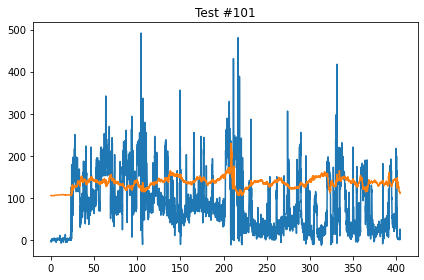

$R^{2}$: 0.02; $E_{real}$: 9.637792, $$\hat{E}$$: 15.233929
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


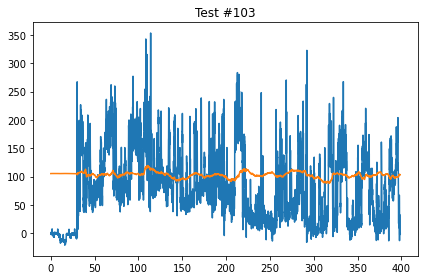

$R^{2}$: 0.02; $E_{real}$: 9.078459, $$\hat{E}$$: 11.401537
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


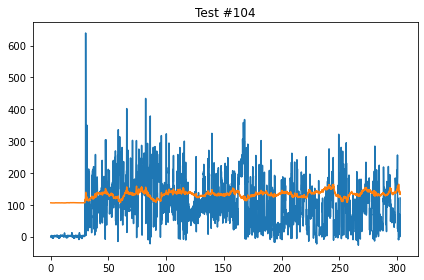

$R^{2}$: 0.02; $E_{real}$: 8.499014, $$\hat{E}$$: 10.963891
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


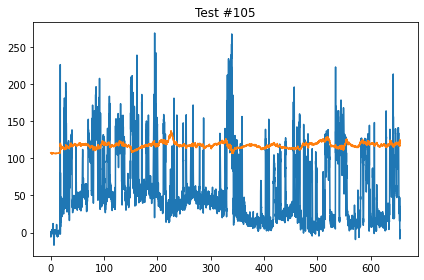

$R^{2}$: 0.02; $E_{real}$: 10.750463, $$\hat{E}$$: 21.361985
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


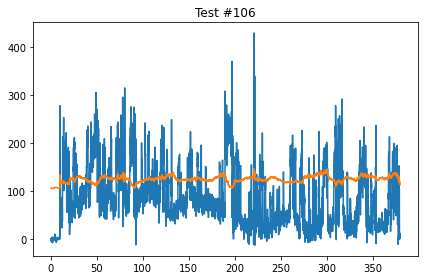

$R^{2}$: 0.02; $E_{real}$: 9.325046, $$\hat{E}$$: 13.161490
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


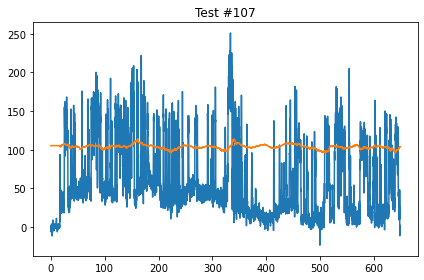

$R^{2}$: 0.02; $E_{real}$: 10.778806, $$\hat{E}$$: 18.706299
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


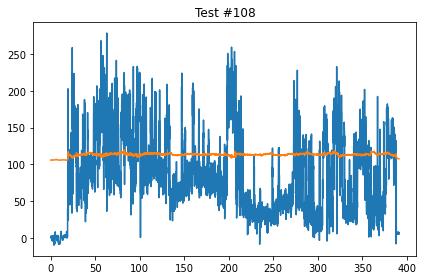

$R^{2}$: 0.02; $E_{real}$: 9.392251, $$\hat{E}$$: 12.290033
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


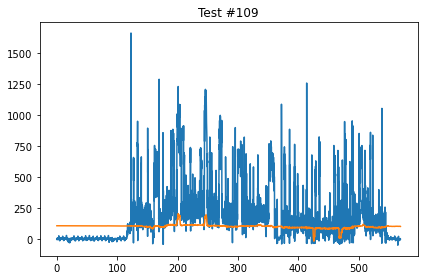

$R^{2}$: 0.02; $E_{real}$: 30.609911, $$\hat{E}$$: 15.775963
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


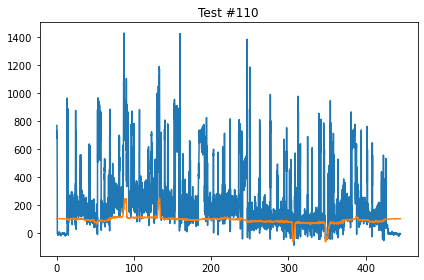

$R^{2}$: 0.02; $E_{real}$: 28.982423, $$\hat{E}$$: 11.878288
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


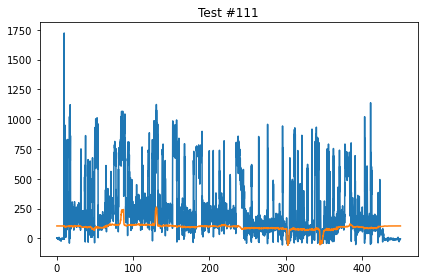

$R^{2}$: 0.02; $E_{real}$: 30.333435, $$\hat{E}$$: 12.049763
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


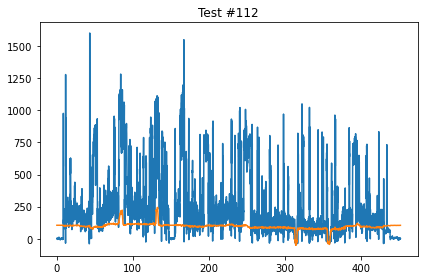

$R^{2}$: 0.02; $E_{real}$: 32.709560, $$\hat{E}$$: 12.174793
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


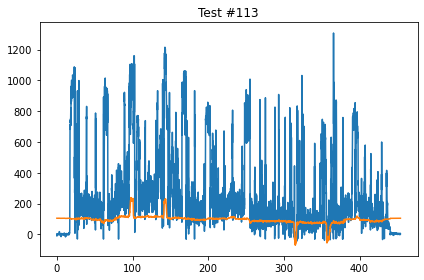

$R^{2}$: 0.02; $E_{real}$: 33.354769, $$\hat{E}$$: 12.162620
[-0.24373810936491858, 3.1997826653053383, -449.28531521261976, 104.37634984003395, 0.9494360395267545]
c5: 105.398405


In [156]:
DF = data.copy()
#DF = DF[DF.route=='A']
X = DF[['x1','x2','x3','x4','x5']]
Y = DF['y']
tests = list(set(DF.test))
reg = LinearRegression().fit(X,Y)
DF['P_hat'] = reg.predict(X)

e_real = []
e_hat = []
route = []

for test in tests: 
    df = DF[DF.test==test]
    E_real = scipy.integrate.simps(df['y'], x=df["time"], even="avg") / 3600
    E_hat = scipy.integrate.simps(df['P_hat'], x=df["time"], even="avg") / 3600
    e_real.append(E_real)
    e_hat.append(E_hat)
    route.append(list(set(df.route))[0])
    plt.plot(df.time, df.y)
    plt.plot(df.time, df.P_hat)
    plt.title("Test #%d"%(test))
    plt.show()
    #a = 1/0
    print("$R^{2}$: %.2f; $E_{real}$: %f, $$\hat{E}$$: %f"%(reg.score(X,Y), E_real, E_hat))
    print(list(reg.coef_))
    print("c5: %f"%(reg.intercept_))

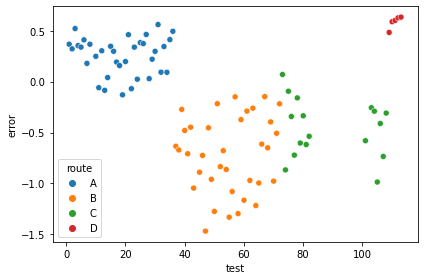

In [19]:
summary = pd.DataFrame({"test":tests, "E_real":e_real, "E_hat":e_hat, 'route':route})
summary['error'] = (summary.E_real - summary.E_hat)/summary.E_real
sns.scatterplot(x="test", y="error", data = summary, hue='route')
plt.show()

In [20]:
print(np.fabs(summary.error).mean())
print()

0.49720397536507216



In [21]:
data.columns

Index(['test', 'time', 'battery_voltage_computer', 'battery_current_computer',
       'battery_voltage_husky', 'battery_current_husky', 'position_x',
       'position_y', 'position_z', 'orientation_x', 'orientation_y',
       'orientation_z', 'orientation_w', 'twist_linear_x', 'twist_linear_y',
       'twist_linear_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'temperature', 'humidity', 'route', 'speed',
       'payload', 'roll_x', 'pitch_y', 'yaw_z', 'power', 'a', 'a_total', 'V',
       'Z', 'tf', 'x1', 'x2', 'x3', 'x4', 'y', 'current', 'voltage', 'vx',
       'vy', 'vz', 'pitch', 'ax', 'ay', 'az', 'p', 'v', 'z', 'x5'],
      dtype='object')

In [22]:
def calculate_distance(df):
    df = df.reset_index()
    d = 0
    for i in range(len(df)-1):
        coords_2 = (df.position_y[i], df.position_x[i])
        coords_1 = (df.position_y[i+1], df.position_x[i+1])
        d += geopy.distance.geodesic(coords_1, coords_2).km
    return d

In [23]:
speed = []
payload = []
distance = []
temp = []
humid = []

for test in tests: 
    df = DF[DF.test==test]
    speed.append(list(set(df.speed))[0])
    humid.append(list(set(df.humidity))[0])
    temp.append(list(set(df.temperature))[0])
    payload.append(list(set(df.payload))[0])
    distance.append(calculate_distance(df))

In [157]:
es = pd.DataFrame() #energy summary
es['test'] = tests
es['e'] = np.array(e_real)/np.array(distance)
es['speed'] = speed
es['distance'] = distance
es['temp'] = temp
es['humid'] = humid
es['payload'] = payload
es['route'] = route
es.e




0     79.692008
1     68.127837
2     70.583282
3     77.990252
4     77.397739
        ...    
87    68.826786
88    76.307806
89    79.141320
90    85.461859
91    85.220827
Name: e, Length: 92, dtype: float64

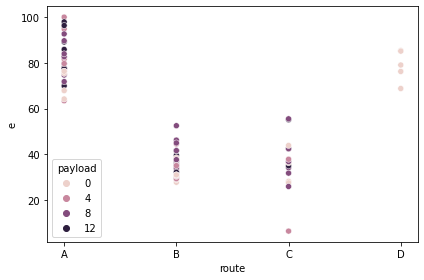

In [25]:
sns.scatterplot(x='route', y='e', hue='payload', data=es)
plt.show()

In [26]:
#df_es = es[es.route=="A"].copy()
df_es = es.copy()
df_es = df_es[df_es.test!=77]

X = df_es[['speed','payload','temp','humid', 'speed2', 'speed3', 'payload2', 'payload3']]
Y = df_es['e']
tests = list(set(df_es.test))
reg = LinearRegression().fit(X,Y)
df_es['e_hat'] = reg.predict(X)

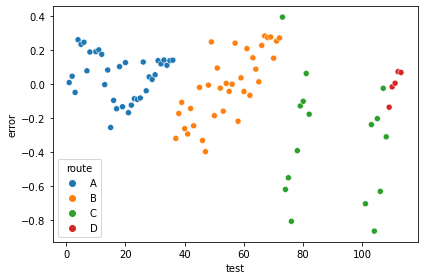

In [27]:
df_es['error'] = (df_es.e - df_es.e_hat)/df_es.e
sns.scatterplot(x="test", y="error", data = df_es, hue='route')
plt.show()

In [28]:
label = ['speed','payload','temp','humid', 'speed2', 'speed3', 'payload2', 'payload3']
for i in range(len(reg.coef_)):
    print("%-8s: %6.2f"%(label[i],reg.coef_[i]))
print("%-8s: %6.2f"%("interc",reg.intercept_))
print("R_sq: %.2f"%(reg.score(X,Y)))

speed   : -32.07
payload :   2.17
temp    :   2.02
humid   :   0.39
speed2  : -11.31
speed3  :  20.52
payload2:  -0.29
payload3:   0.01
interc  :  22.52
R_sq: 0.80


In [29]:
np.fabs(df_es.error).mean()

0.18248464894831945

In [30]:
es.corr()

test         e     speed  distance      temp     humid  \
test      1.000000 -0.496121  0.108508  0.212159 -0.368033 -0.081629   
e        -0.496121  1.000000 -0.113964 -0.034324  0.810488  0.550951   
speed     0.108508 -0.113964  1.000000  0.070391  0.042742  0.094967   
distance  0.212159 -0.034324  0.070391  1.000000  0.191104  0.168389   
temp     -0.368033  0.810488  0.042742  0.191104  1.000000  0.396149   
humid    -0.081629  0.550951  0.094967  0.168389  0.396149  1.000000   
payload  -0.146341  0.020749 -0.103366 -0.108477 -0.177110 -0.047447   
speed2    0.109629 -0.095160  0.992461  0.060898  0.054757  0.093269   
speed3    0.109288 -0.078156  0.974436  0.052163  0.064263  0.090739   
payload2 -0.133466  0.039160 -0.076044 -0.110307 -0.130062 -0.065423   
payload3 -0.132758  0.047033 -0.060320 -0.104413 -0.100864 -0.074552   

           payload    speed2    speed3  payload2  payload3  
test     -0.146341  0.109629  0.109288 -0.133466 -0.132758  
e         0.020749 -0.095160 -0.078156  0.039160  0.047033  
speed    -0.103366  0.992461  0.974436 -0.076044 -0.060320  
distance -0.108477  0.060898  0.052163 -0.110307 -0.104413  
temp     -0.177110  0.054757  0.064263 -0.130062 -0.100864  
humid    -0.047447  0.093269  0.090739 -0.065423 -0.074552  
payload   1.000000 -0.106967 -0.108754  0.957672  0.904065  
speed2   -0.106967  1.000000  0.994625 -0.079771 -0.064532  
speed3   -0.108754  0.994625  1.000000 -0.081983 -0.067331  
payload2  0.957672 -0.079771 -0.081983  1.000000  0.987523  
payload3  0.904065 -0.064532 -0.067331  0.987523  1.000000

0.020568678250965308 243.53077276845082 0.8153881174230349 12.0 0.42083181110536994


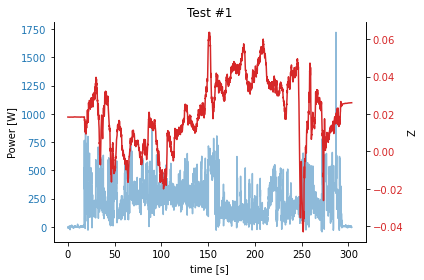

0.020345723384130845 147.66417656236712 0.5869401734000029 0.0 0.3861827868473043


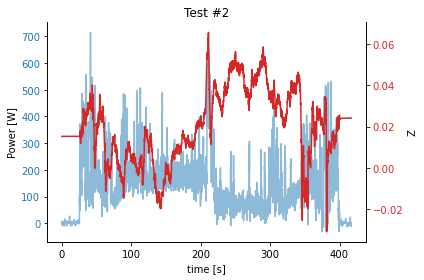

0.019685955290750335 205.6061733450306 0.7827792215415725 0.0 0.45242432345700323


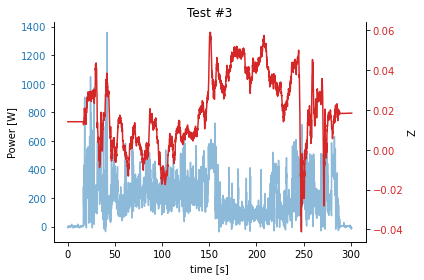

0.017668139914472976 203.45061430498882 0.7122646575611747 8.0 0.4051218099411304


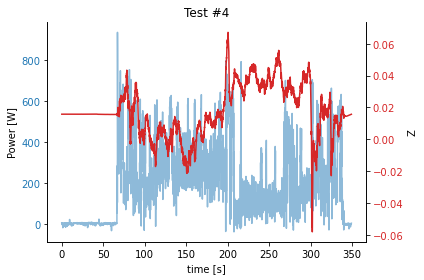

0.01746710235656674 172.30482065773927 0.6064321022316146 4.0 0.41978977556925523


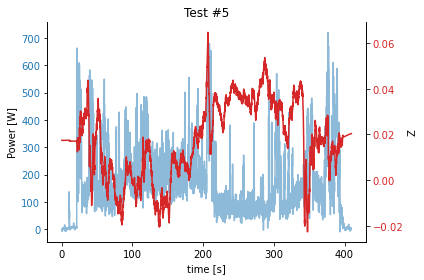

0.018512629280642987 228.8802061104888 0.8011994584735143 8.0 0.4136964125403878


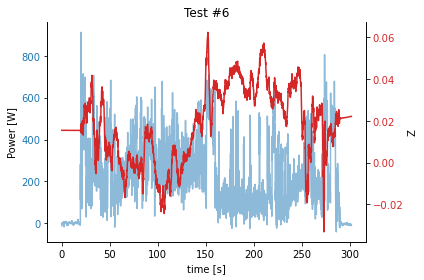

0.023381836321623255 174.26928110702136 0.6067972716664981 12.0 0.4533988562992943


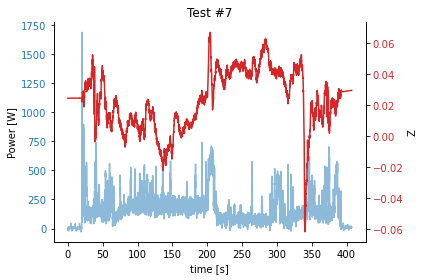

0.023766013580242593 156.2945416268847 0.610207085148917 0.0 0.39618232041915535


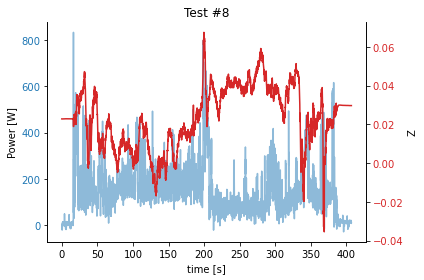

0.020460068299505196 149.43091653588036 0.499914342092437 4.0 0.33385969704045704


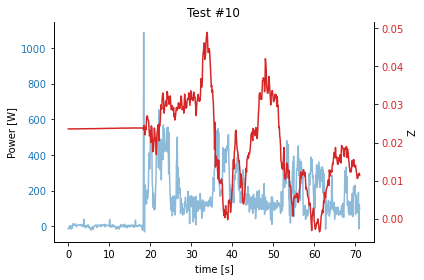

0.02540915995167641 121.83528048578349 0.3507450728873303 12.0 0.43071610377362707


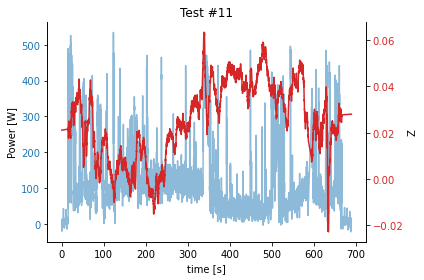

0.03312444509017085 234.00819013784007 0.8169331644111146 12.0 0.49216134820268614


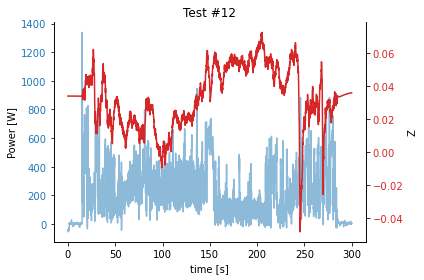

0.03251309150016806 93.0188503175591 0.2988911343474124 0.0 0.3289770862035378


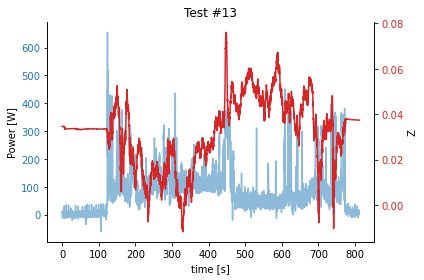

0.031207571293149355 115.0076088807489 0.34319940958362016 4.0 0.38804139533832277


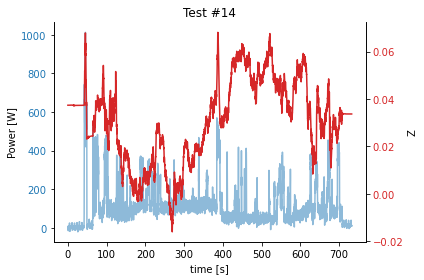

0.014886802438023268 177.9402595598523 0.769774942607795 4.0 0.43611748716961013


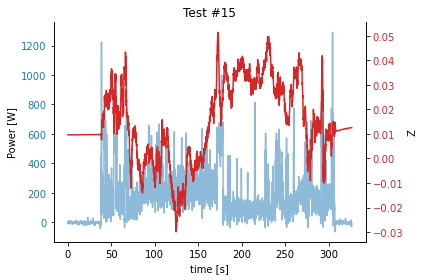

0.01603847423122711 161.92868299453949 0.5775076872372701 4.0 0.4210470291171878


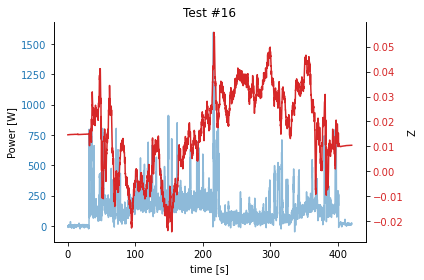

0.016764887619793348 155.26645280790652 0.5773261817651517 8.0 0.40637090682427174


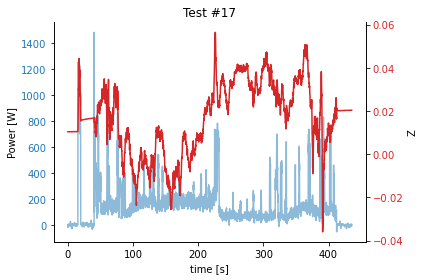

0.014795246620967603 130.93670816398853 0.3536727160518846 4.0 0.37762653958119424


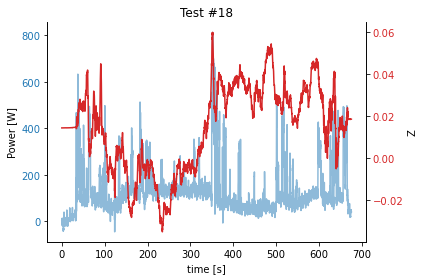

0.014491439077319186 109.1877861753027 0.3397298399920751 12.0 0.36540274940440676


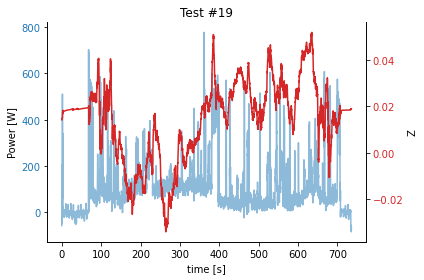

0.013837714969817085 128.87282671868837 0.3592046368355912 0.0 0.36862610663417306


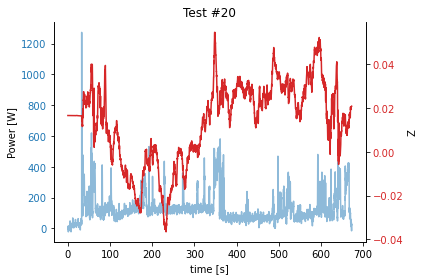

0.014718540954085342 186.95871956276432 0.7560721494251403 0.0 0.40188478661944255


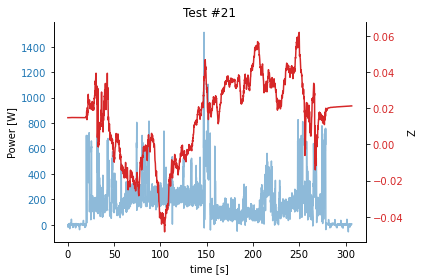

0.016153536633573166 96.40396036833852 0.33283825020849245 0.0 0.3624622080186539


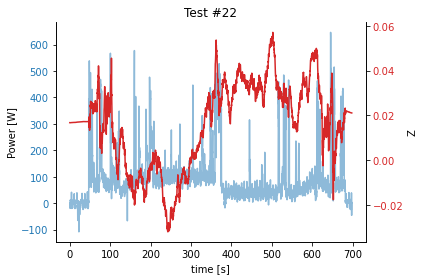

0.016564267515250707 224.80971107585125 0.7733683609781893 12.0 0.41088795205429895


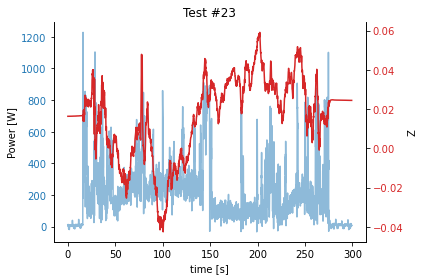

0.014683408682919551 112.96991354157312 0.35591100628012484 4.0 0.3709633840559768


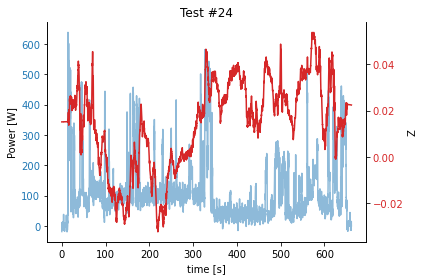

0.01642136989499926 214.72974128824399 0.7558709241604207 8.0 0.39054244620947587


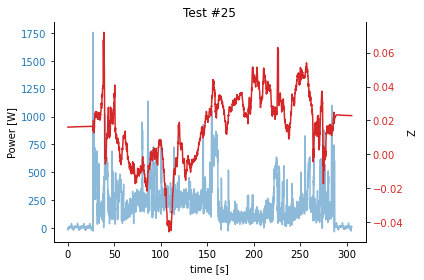

0.01425926786403717 220.06527256064615 0.5966652013244711 12.0 0.39378890372671504


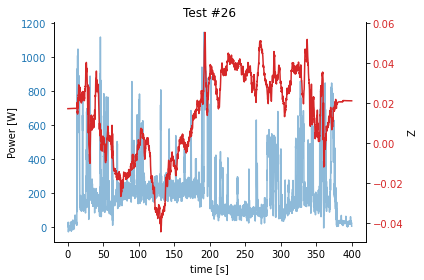

0.016937383619388933 215.39425858850228 0.7289768648694482 4.0 0.39054126287300084


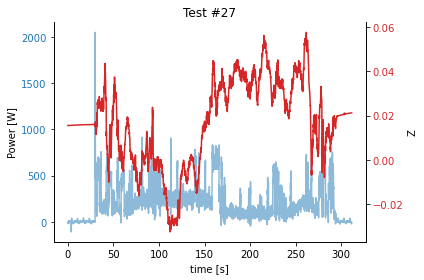

0.014464280392833151 127.4502377067188 0.3341764479396805 12.0 0.3669554108928897


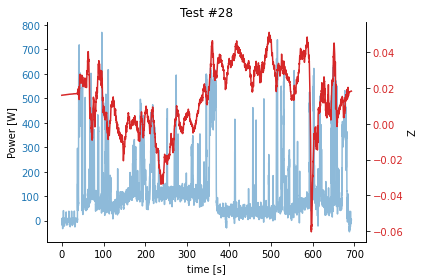

0.01594188319124048 175.51840976191247 0.5672933517790606 12.0 0.3694175374862621


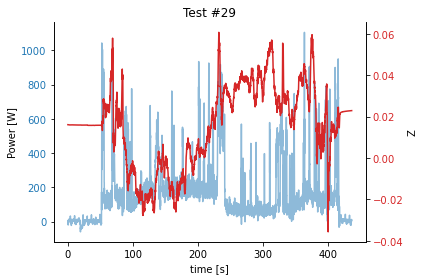

0.016709833927945627 180.23265326277928 0.5878676111253991 8.0 0.43246077849318443


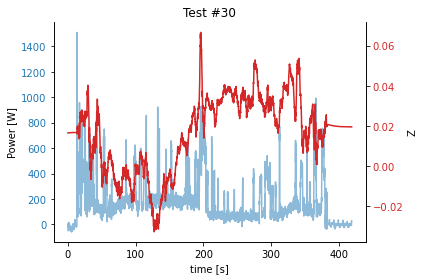

0.01950934315360168 224.38816896929032 0.8048337027566057 0.0 0.41665659738348176


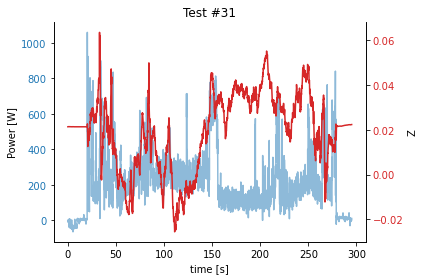

0.01687906904165849 128.4114848387603 0.3098602685068574 8.0 0.36922687871812926


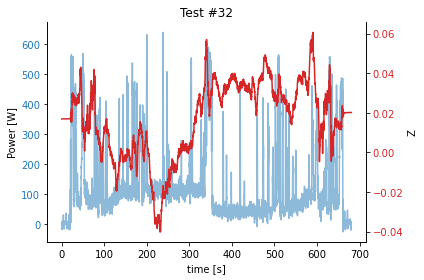

0.015351760091247562 193.01159085447875 0.5981602078760121 8.0 0.4047005188927662


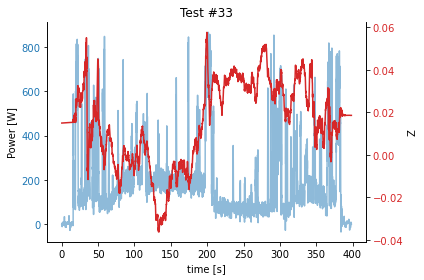

0.017229613433792753 130.12182707671286 0.3600093488402215 8.0 0.3702942341421301


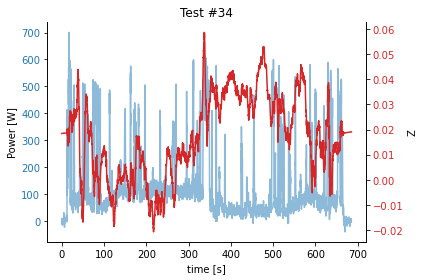

0.017317371435115907 171.91249180274977 0.5898858432729222 0.0 0.3859970485558884


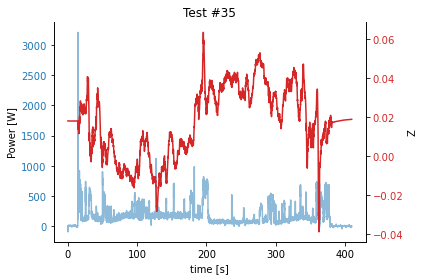

0.015891992933636866 231.47661343412577 0.7807690586383628 4.0 0.4527282209678977


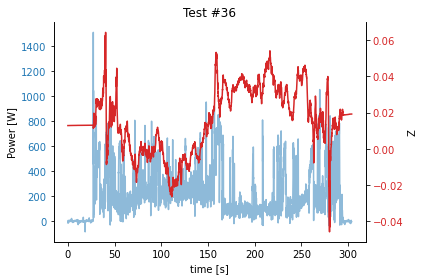

0.005673796674539767 87.30217673120879 0.7873455407952583 12.0 0.3141590464760345


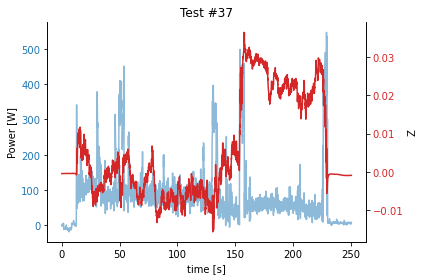

0.007124583385836413 61.868514176518204 0.5995800021393931 0.0 0.3152406341898275


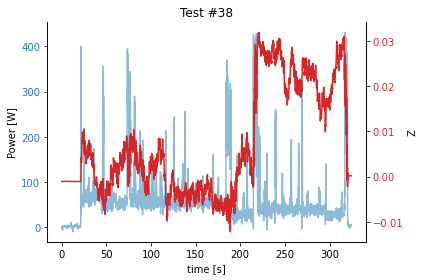

0.005347758553234704 80.82999629133799 0.7357065096447004 0.0 0.28975643495455417


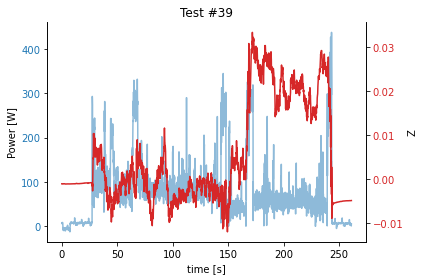

0.006175634626793996 87.62814799813071 0.7831462550661888 8.0 0.31125564139377576


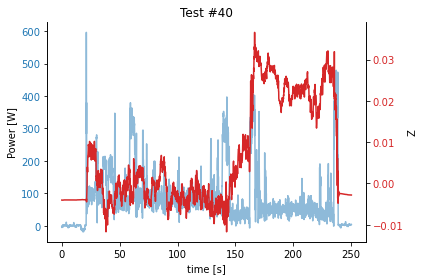

0.007077609875183579 66.30573536126083 0.5976355884460425 4.0 0.3046038289249442


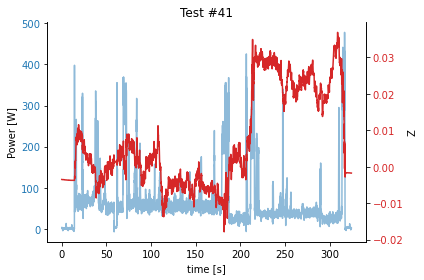

0.006517735663333682 88.32307422394287 0.7207159141329572 8.0 0.3212843417501766


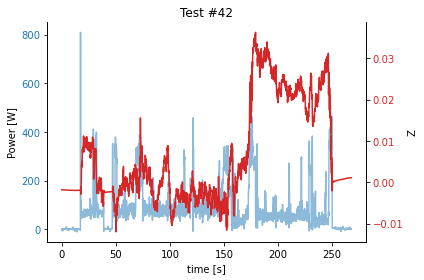

0.005878577070839939 63.27734708745927 0.4883570642748327 12.0 0.2364869422648549


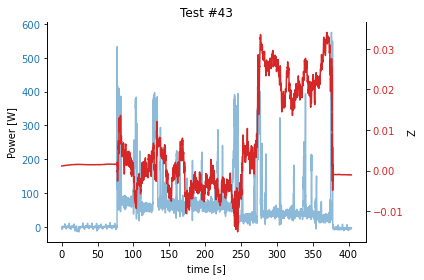

0.007010500149683503 61.38713977996724 0.3513315307161057 8.0 0.2737125569886365


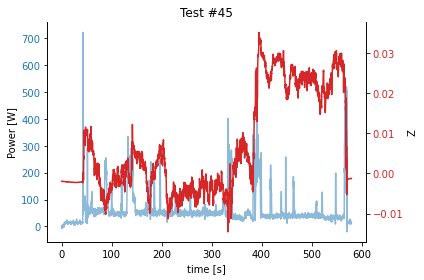

0.005767095671291868 65.63338533332359 0.6019927173559678 4.0 0.2755798580905034


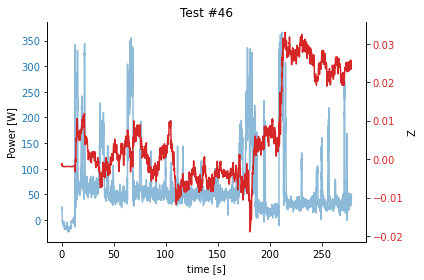

0.007180254823671397 49.249812134882866 0.3439827931277172 12.0 0.40530891582766115


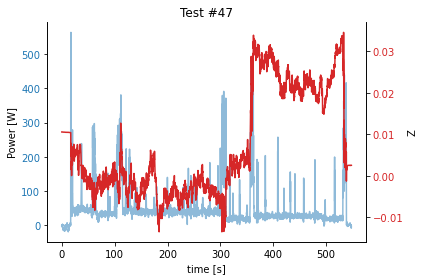

0.0070028742345408955 100.6477194389014 0.8278931798236209 12.0 0.46319236039092476


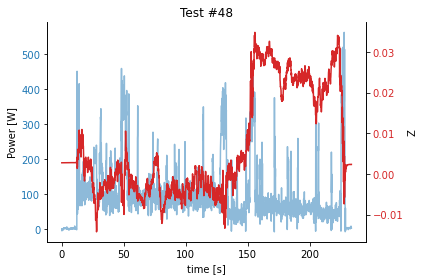

0.0032120019150419883 53.72090081367884 0.3383877737573115 0.0 0.3046314647979119


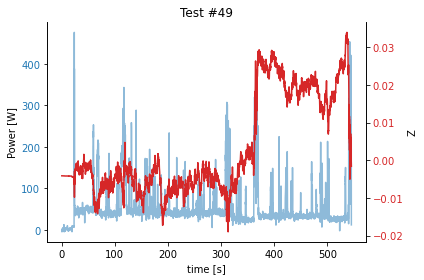

0.003498909517547232 48.25678061376869 0.33372625424382457 4.0 0.36872845092036455


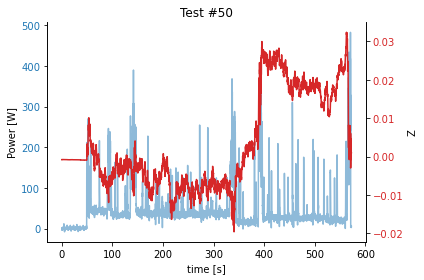

0.003360713059080459 96.0277029176691 0.7988098322802942 4.0 0.41751807993187384


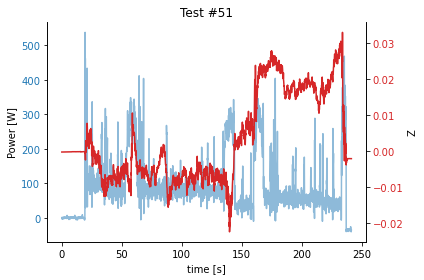

0.003537092852254594 61.763776909426454 0.5512575689640005 4.0 0.4733209850911641


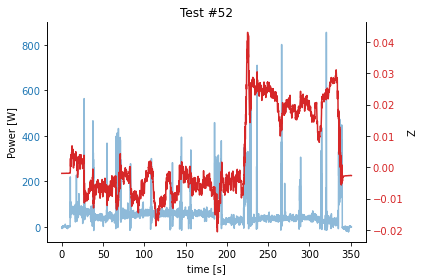

0.0029421221783876607 72.95259535004725 0.5564309341272659 8.0 0.4276161548539595


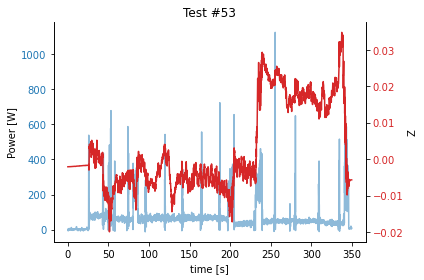

0.004660706616550482 59.24121634244685 0.37269838287168366 4.0 0.2974542789752134


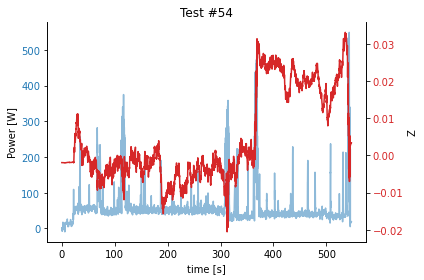

0.005063165602048147 52.26780154368037 0.3495248516005317 12.0 0.3615560458881419


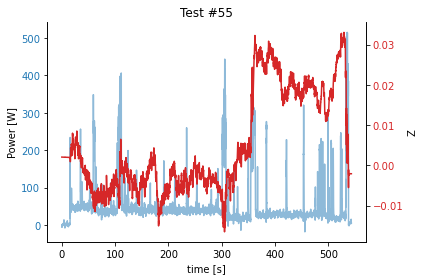

0.004134236143640226 50.264955829983684 0.35001104866699695 0.0 0.3871335612403588


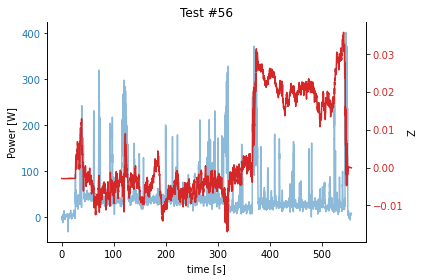

0.0032464187613632494 90.52016102272442 0.7869839352382487 0.0 0.4003451669053036


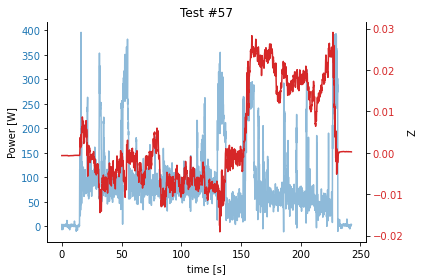

0.0037646891440926123 45.57806362046881 0.35466228076600975 0.0 0.4074398492252827


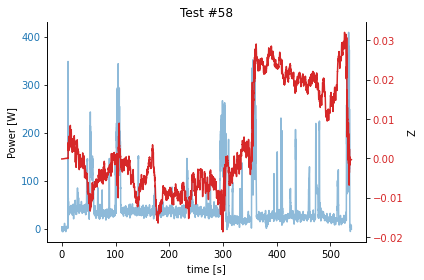

0.0036983322325348966 103.57412456345622 0.7906717726848363 12.0 0.3950449793069631


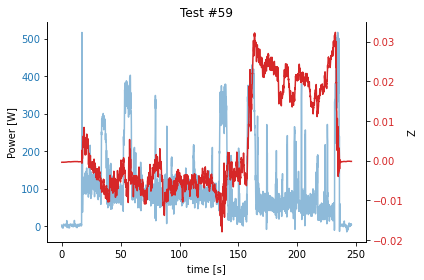

0.00289343380686546 50.87638492212786 0.3646993193840483 4.0 0.3118763028431621


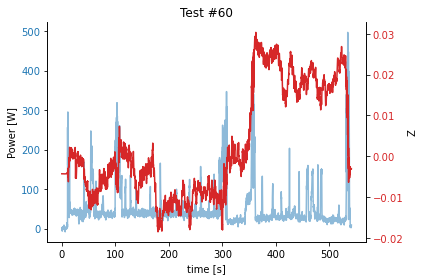

0.003319012422689486 100.45417650363419 0.8040249825836718 8.0 0.39285759508020623


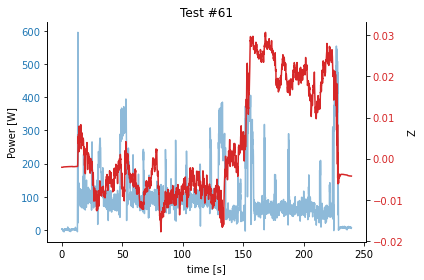

0.002960250854165599 66.29320863054465 0.5715446455812745 12.0 0.3359890561457816


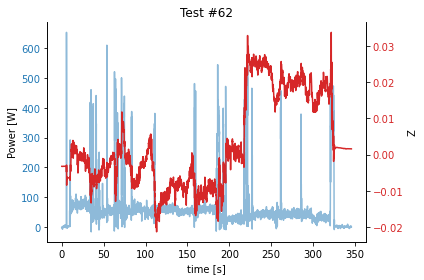

0.0032533398584958595 92.14823220761056 0.7920131007998517 4.0 0.34644655401928204


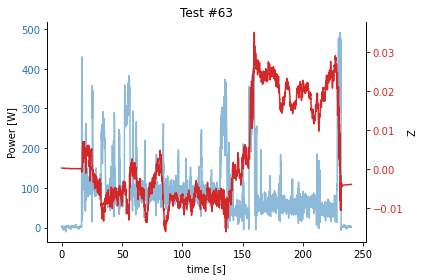

0.0032823129040738972 54.74154312409737 0.34632298163039477 12.0 0.290525019279829


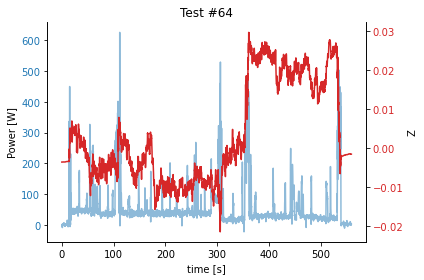

0.003961712731806162 65.79251102805675 0.559156147992926 12.0 0.39922312461858583


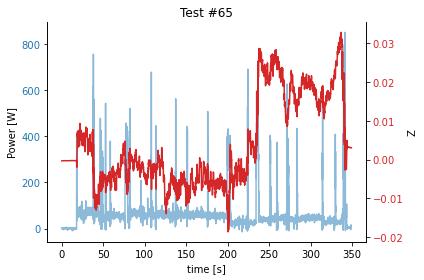

0.00373149146128915 75.90260091620067 0.5491024457180892 8.0 0.3952930490377565


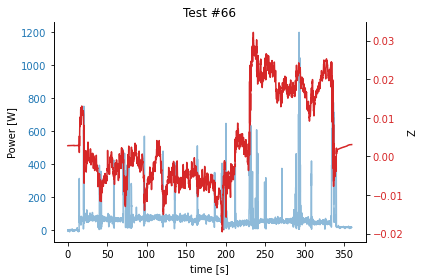

0.004152925851674658 90.31021262310449 0.7731208571554918 0.0 0.43197128784518707


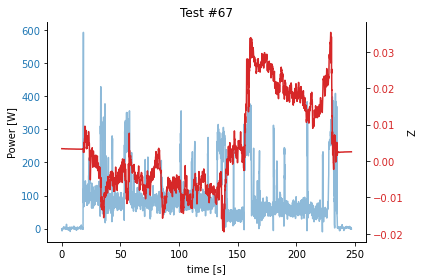

0.004438352013470368 70.51611705785075 0.3483739789155296 8.0 0.4231913805085291


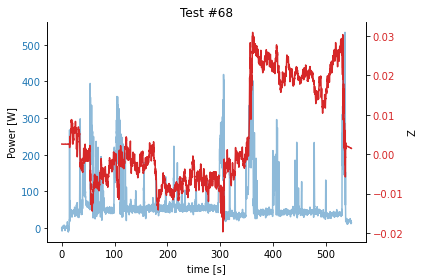

0.003987335042386102 88.47693954561002 0.5779022117230025 8.0 0.371788899515311


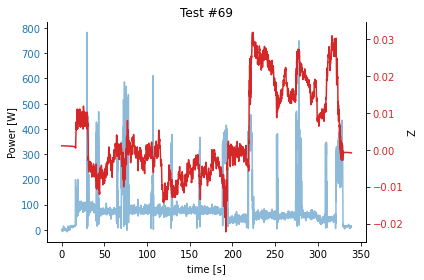

0.004079128458284015 58.554698419989926 0.34826853699053945 8.0 0.37802871870671645


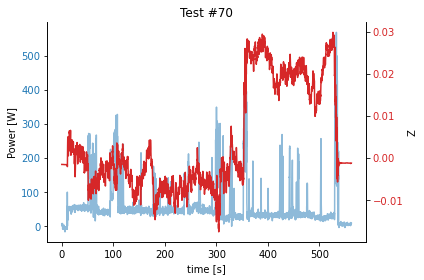

0.004179358768772747 69.07382133233541 0.6108447790736838 0.0 0.3890752704856572


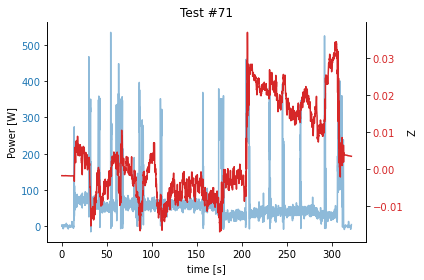

0.0029058240042073133 95.05006185136764 0.7295535688717192 4.0 0.431855811528075


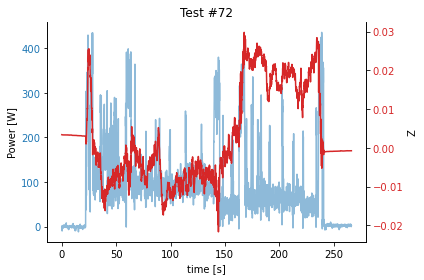

0.006723073132568737 154.70853689255435 0.7613056807969765 12.0 0.4980962923550377


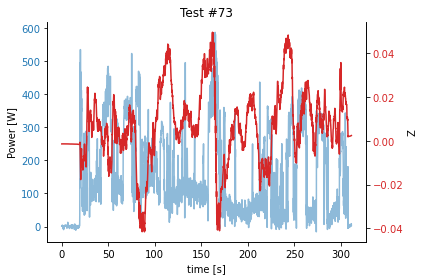

0.0034730694448929763 55.5086314945802 0.48130599532177326 0.0 0.3709779687419779


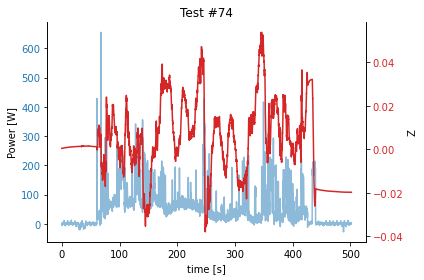

0.006495758342347678 93.90641937652131 0.832276649870597 0.0 0.5576551557631342


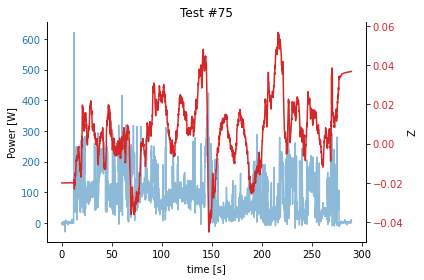

0.004084922338946917 98.09345091611947 0.8321577944967885 8.0 0.514977824073616


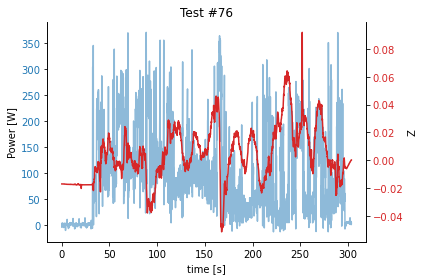

0.008232965461024054 113.16201690807351 0.7871216732155224 8.0 0.5193836155518855


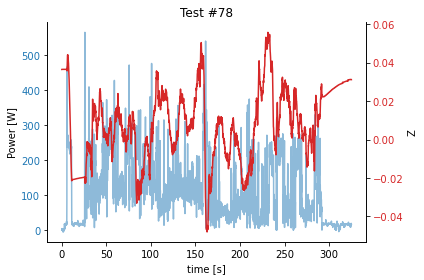

0.011973841235129267 82.19778031924187 0.5253299890576153 12.0 0.43199111365811665


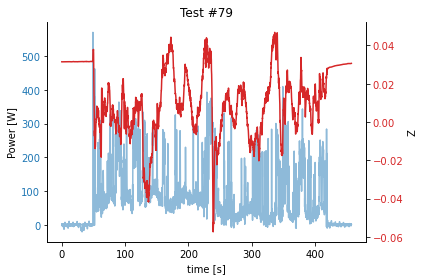

0.006925118198468469 77.46575662710956 0.585908403853022 0.0 0.5072935817896018


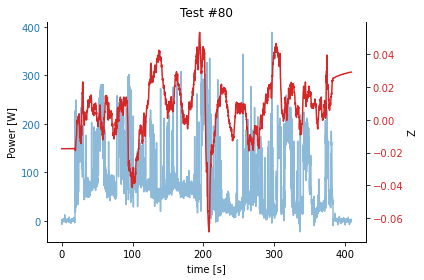

0.00860877499835802 72.20498298377095 0.3593507489077879 8.0 0.46804322243505675


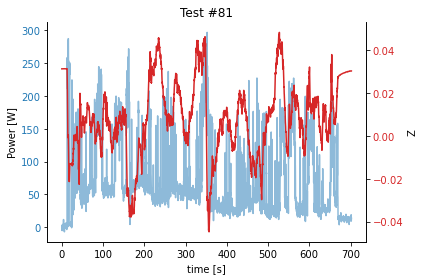

0.007221691546458446 73.62330178190439 0.5481738516915976 4.0 0.44180667466416557


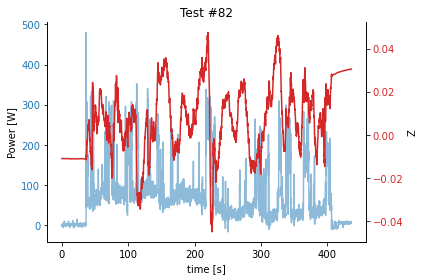

0.008585301795795138 85.93946238925982 0.598570196333283 12.0 0.42982675703194556


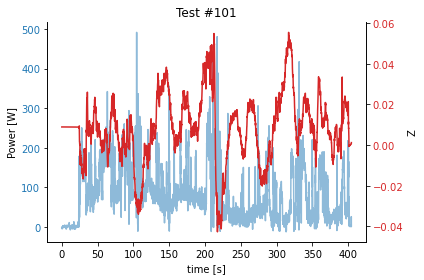

0.00835897965068019 81.99962119135076 0.5927648094557199 0.0 0.4063046554505306


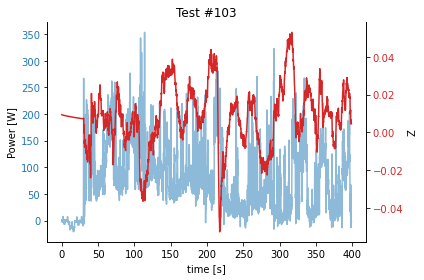

0.007949017717533178 101.04290082885635 0.762926499696577 8.0 0.4780630869186952


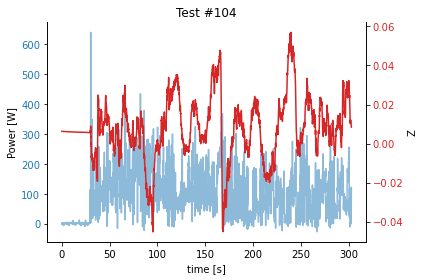

0.00895625142308755 59.02309412426759 0.36900014138218745 8.0 0.41879091431576787


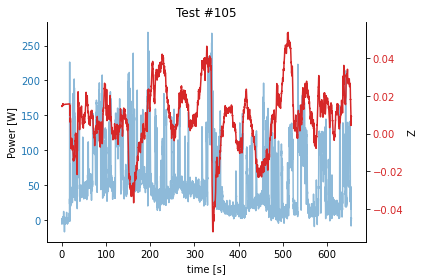

0.008645050105201743 88.5072276135777 0.595211917928884 8.0 0.4446069195684269


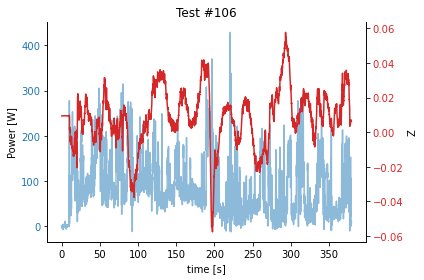

0.00918893719476041 59.8280752469678 0.355923672486761 0.0 0.41397723647671625


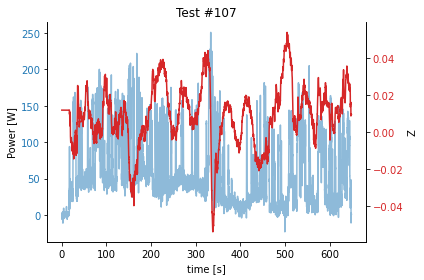

0.009268789218078657 86.1939162828407 0.5486244357262325 4.0 0.4190841437982726


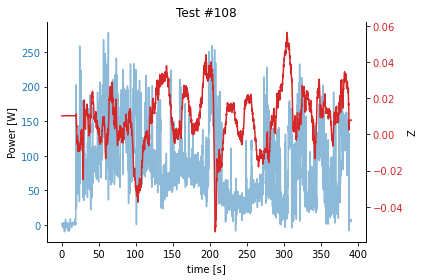

0.021374121946904776 192.70394692641773 0.5326825657479927 0.0 0.389618283372605


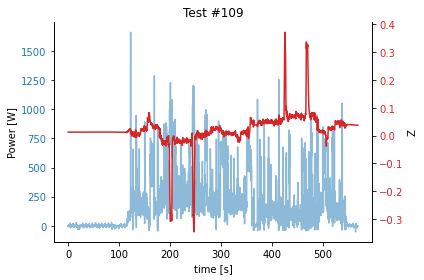

0.023567930859758036 233.14890939323354 0.872857450080064 0.0 0.4727678135466858


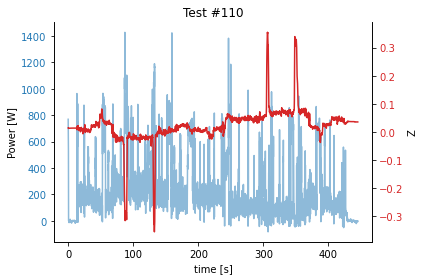

0.02331328149720896 241.48225755335636 0.8631660201078042 0.0 0.473456336943732


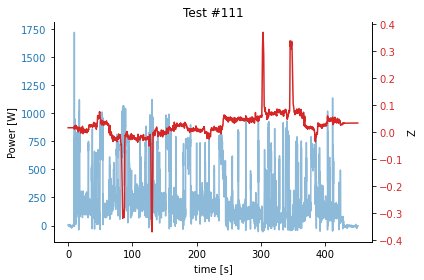

0.02162673542618121 261.2548092520924 0.7982479775352064 0.0 0.4862177930812969


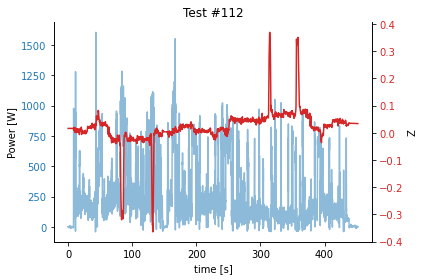

0.02267084872417398 264.5954910069933 0.8658595416251528 0.0 0.46446481979796167


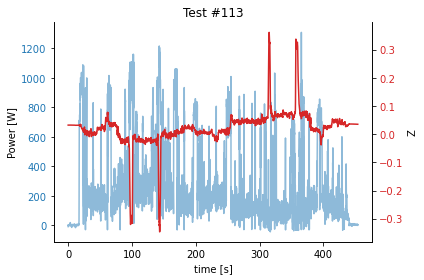

In [31]:
for test in tests:
    df = data[data.test == test].copy()
    df = df.reset_index()
    print(df.Z.mean(), df.power.mean(), df.V.mean(), df.payload.mean(), df.a.mean())
    fig, ax1 = plt.subplots()
    
    color = "tab:blue"
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel("Power [W]")
    ax1.plot(df.time, df.power, color=color, alpha=0.5 )
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = "tab:red"
    ax2.set_ylabel("Z")
    ax2.plot(df.time, df.Z, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    sns.despine(top=True, right=False)
    plt.title("Test #%d"%(test))
    plt.show()

In [32]:
print(data.columns)

Index(['test', 'time', 'battery_voltage_computer', 'battery_current_computer',
       'battery_voltage_husky', 'battery_current_husky', 'position_x',
       'position_y', 'position_z', 'orientation_x', 'orientation_y',
       'orientation_z', 'orientation_w', 'twist_linear_x', 'twist_linear_y',
       'twist_linear_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'temperature', 'humidity', 'route', 'speed',
       'payload', 'roll_x', 'pitch_y', 'yaw_z', 'power', 'a', 'a_total', 'V',
       'Z', 'tf', 'x1', 'x2', 'x3', 'x4', 'y', 'current', 'voltage', 'vx',
       'vy', 'vz', 'pitch', 'ax', 'ay', 'az', 'p', 'v', 'z', 'x5'],
      dtype='object')


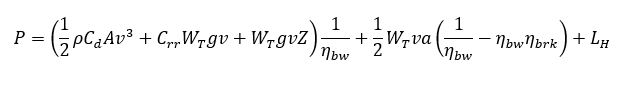

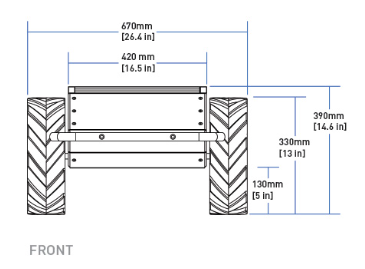

In [34]:
def power(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh):
    drag = 0.5*rho*Cd*A*(v**3)
    friction = Crr*Wt*g*v
    slope = Wt*g*v*Z
    acceleration = 0.5*Wt*v*a
    power = (drag + friction + slope)/nbw + acceleration*(1/nbw - nbw*nbr) + Lh
    return power, drag, friction, slope, acceleration    

In [35]:
rho = 1.2
g = 9.81
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
v = 0.8
payload = 12 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.35
nbr = 0
Lh = 0

p, drag, friction, slope, acceleration = power(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)
print("Power: %.2f W\nDrag: %.2f\nFriction: %.2f\nSlope: %.2f\nAcceleration: %.2f"%(p, drag, friction, slope, acceleration))



Power: 70.30 W
Drag: 0.09
Friction: 4.87
Slope: 9.73
Acceleration: 9.92


In [ ]:
df.to_csv("test1.csv", index=False)

In [ ]:
def energy_analysis(data, test, rho, g, Crr, Cd, A, nbw, nbr, Lh, W_husky):
    
    df = data[data.test == test].copy()
    df = df.reset_index()
    sigma = 15
    df['power_smooth'] = scipy.ndimage.filters.gaussian_filter(df.power,sigma)
    Drag, Friction, Slope, Acceleration = [], [], [], []    
    p_hat = []
    for i in range(len(df)):
        v = df.loc[i,'V']
        Wt = W_husky + df.payload.mean()
        
        Z = -df.loc[i,'Z']
        #if Z<0:
        #   Z = 0      
        
        a = df.loc[i, 'a']
        p, drag, friction, slope, acceleration = power(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)
        Drag.append(drag)
        Friction.append(friction)
        Slope.append(slope)
        Acceleration.append(acceleration)
        p_hat.append(p)
    
    plt.plot(df.time,Drag, label='drag', color='gray')
    #plt.plot(df.time,Friction, label='friction')
    #plt.plot(df.time,Slope, label='slope')
    #plt.plot(df.time,Acceleration, label='acceleration')
    sns.despine(top=True, right=True)
    plt.title("Drag")
    plt.ylabel("Power [W]", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.show()
    
    
    plt.plot(df.time,Friction, label='friction', color='red')
    #plt.plot(df.time,Slope, label='slope')
    #plt.plot(df.time,Acceleration, label='acceleration')
    sns.despine(top=True, right=True)
    plt.title("Friction")
    plt.ylabel("Power [W]", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.show()
    
    
    plt.plot(df.time,Slope, label='slope', color='orange')
    #plt.plot(df.time,Acceleration, label='acceleration')
    sns.despine(top=True, right=True)
    plt.title("Slope")
    plt.ylabel("Power [W]", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.show()
    
    
    plt.plot(df.time,Acceleration, label='acceleration', color='#89CFF0')
    sns.despine(top=True, right=True)
    plt.title("Acceleration")
    plt.ylabel("Power [W]", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.show()
    
    
    df['p_hat'] = p_hat
    e_real = scipy.integrate.simps(y=df.power_smooth, x=df["time"], even="avg") / 3600
    e_hat = scipy.integrate.simps(y=df.p_hat, x=df["time"], even="avg") / 3600
    ARE = np.fabs((e_real-e_hat)/e_real)
    print("E_real: %.4f Wh,E_hat: %.4f Wh, ARE: %.2f %%"%(e_real, e_hat, ARE*100))
    fig, ax1 = plt.subplots()
    
    color = "tab:black"
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel("Power Observed [W]", fontsize=14)
    ax1.plot(df.time, df.power_smooth, color="black")
    ax1.tick_params(axis='y', labelcolor="black")
    ax1.set_ylim(0,600)

    ax2 = ax1.twinx()

    color = "tab:blue"
    ax2.set_ylabel("p_hat")
    ax2.plot(df.time, df.p_hat, color="#0000FF", alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel("$\hat{P}$ [W]", fontsize=14)
    ax2.set_ylim(0,600)

    fig.tight_layout()
    sns.despine(top=True, right=False)
    plt.title("Test #%d"%(test))
    plt.show()
    
    
    e_drag = scipy.integrate.simps(Drag, x=df["time"], even="avg") / 3600
    e_friction = scipy.integrate.simps(Friction, x=df["time"], even="avg") / 3600 
    e_slope = scipy.integrate.simps(Slope, x=df["time"], even="avg")  / 3600
    e_acceleration = scipy.integrate.simps(Acceleration, x=df["time"], even="avg") / 3600
    
    print("Drag: %.4f Wh, friction: %.4f Wh, slope: %.4f Wh, acceleration: %.4f Wh"%(e_drag, e_friction, e_slope, e_acceleration))        
    sns.barplot(x=["drag", 'friction', 'slope', 'acceleration'], y=[e_drag, e_friction, e_slope, e_acceleration])
    sns.despine(top=True, right=True)
    plt.ylabel("Energy [Wh]")
    plt.show()
    return e_real, e_hat, ARE
    

In [ ]:
rho = 1.2 # kg/m^3
g = 9.81 # m/s^2
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
nbw = 1
nbr = 0.0
Lh = 0
W_husky = 50
test = 1

energy_analysis(data, test, rho, g, Crr, Cd, A, nbw, nbr, Lh, W_husky)

In [ ]:
rho = 1.2 # kg/m^3
g = 9.81 # m/s^2
Crr = 0.3 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
nbw = 0.6
nbr = 0.0
Lh = 0
W_husky = 50
test = 1

energy_analysis(data, test, rho, g, Crr, Cd, A, nbw, nbr, Lh, W_husky)

In [ ]:
rho = 1.2 # kg/m^3
g = 9.81 # m/s^2
Crr = 0.3 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
nbw = 0.6
nbr = 0.0
Lh = 0
W_husky = 50


E_real, E_hat, ARE, route= [], [], [], []

tests = list(set(data.loc[(data.route=="A")&(data.test!=10),'test']))
#tests = list(set(data.loc[(data.test!=10),'test']))
for test in tests: 
    print("Test", test)
    e_real, e_hat, error = energy_analysis(data, test, rho, g, Crr, Cd, A, nbw, nbr, Lh, W_husky)

    E_real.append(e_real)
    E_hat.append(e_hat)
    ARE.append(error)

In [ ]:
summary = pd.DataFrame({"e_real":E_real, "e_hat":E_hat, "ARE": ARE})
summary["route"] = "A"
xs = []
for i in range(len(summary)):
    xs.append(np.random.normal(i/100 + 1, 0.04)) 
summary['xs'] = xs
summary

In [ ]:
figure, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='e_hat', y='e_real', data = summary)
plt.xlabel("Energy Predicted [Wh]", fontsize=14)
plt.ylabel("Energy Observed [Wh]", fontsize=14)
plt.xlim(0,30)
plt.ylim(0,30)
sns.despine(top=True, right=True)
plt.grid(which="Major", alpha=0.5)
plt.show()

In [ ]:
figure, ax = plt.subplots(figsize=(2, 6))
sns.boxplot(x="route", y="ARE", data=summary)
#sns.scatterplot(x="xs", y=ARE, data=summary, x_jitter=True)
sns.despine(top=True, right=True)

plt.show()

In [ ]:
df = data[data.test==1].copy()

#df = data.copy()

df['Z_flipped'] = -df.Z

plt.plot(df.time, df.Z)
plt.plot(df.time, df.Z_flipped)
plt.show()



W_husky = 50
df['Wt'] = W_husky + df.payload
x1 = df.Wt*9.81*df.V
x2 = df.Wt*9.81*df.V*df.Z_flipped+0.5*df.Wt*df.a

model = pd.DataFrame({"x1":x1,"x2":x2})

In [ ]:
sns.pairplot(model)
plt.show()

In [ ]:
X = model[['x1','x2']]
Y = df['y']
#X = sm.add_constant(X)

mod = sm.OLS(Y, X)
res = mod.fit()
print(res.summary())
c1, c2 = res.params

nbw = 1/c2
Crr = c1*nbw

print(Crr, nbw)

In [ ]:
y_pred = res.predict(X)
plt.plot(df.time, Y)
plt.plot(df.time, y_pred)
e_real = scipy.integrate.simps(y=Y, x=df["time"], even="avg") / 3600
e_hat = scipy.integrate.simps(y=y_pred, x=df["time"], even="avg") / 3600
ARE = np.fabs((e_real-e_hat)/e_real)
print("E_real: %.4f Wh,E_hat: %.4f Wh, ARE: %.2f %%"%(e_real, e_hat, ARE*100))
plt.show()

In [ ]:
outliers = [10, 102,103,104]

In [41]:
B = data[data.route=="B"].copy()
tests = list(set(B.test))

In [65]:
def calc_drag(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh):
    drag = 0.5*rho*Cd*A*(v**3)
    friction = Crr*Wt*g*v
    slope = Wt*g*v*Z
    acceleration = 0.5*Wt*v*a
    power = (drag + friction + slope)/nbw + acceleration*(1/nbw - nbw*nbr) + Lh

    return power, drag, friction, slope, acceleration   

In [99]:
rho = 1.2
g = 9.81
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
v = 1
payload = 12 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.35
nbr = 0
Lh = 0


E_real = []
E_drag_21 = []
E_drag_50 = []
E_drag_100 = []
for test in tests:
    
    df = B[B.test==test].copy()
    v = df.speed.min()
    power, drag, friction, slope, acceleration = calc_drag(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)
    t = df.time.max() - df.time.min()
    e_real = scipy.integrate.simps(y=df['power'], x=df["time"], even="avg") / 3600
    e_drag = drag*t/3600
    E_real.append(e_real)
    E_drag.append(e_drag)

    
    

In [100]:
drag_ratio = 1-(np.array(E_real)-np.array(E_drag))/np.array(E_real)

C:\Users\thiag\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


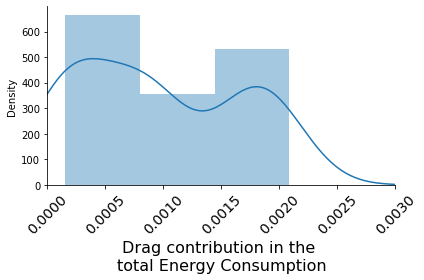

In [120]:
drag_df = pd.DataFrame({"test":tests,"e_real": E_real, "e_drag":E_drag,"drag_ratio":drag_ratio})
sns.distplot(drag_ratio)
plt.xticks(rotation=45, fontsize=14)
plt.xlim(0,0.003)
plt.xlabel("Drag contribution in the \ntotal Energy Consumption", fontsize=16)
sns.despine(top=True, right=True)
plt.show()



In [121]:
rho = 1.2
g = 9.81
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
v = 1
payload = 12 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.35
nbr = 0
Lh = 0


power, drag, friction, slope, acceleration = calc_drag(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)

(88.0441142857143, 0.16884000000000002, 6.0822, 12.1644, 12.4)

C:\Users\thiag\AppData\Local\Temp/ipykernel_11760/3476726717.py:15: RuntimeWarning: invalid value encountered in true_divide
  drag_ratio = 1 - (E_total-E_Drag)/(E_total)
C:\Users\thiag\AppData\Local\Temp/ipykernel_11760/3476726717.py:15: RuntimeWarning: invalid value encountered in true_divide
  drag_ratio = 1 - (E_total-E_Drag)/(E_total)
C:\Users\thiag\AppData\Local\Temp/ipykernel_11760/3476726717.py:15: RuntimeWarning: invalid value encountered in true_divide
  drag_ratio = 1 - (E_total-E_Drag)/(E_total)
C:\Users\thiag\AppData\Local\Temp/ipykernel_11760/3476726717.py:15: RuntimeWarning: invalid value encountered in true_divide
  drag_ratio = 1 - (E_total-E_Drag)/(E_total)


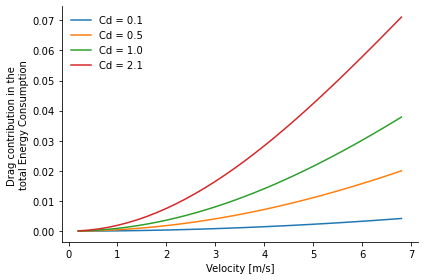

In [140]:
t = 300

Cds = [0.1, 0.5, 1.0 , 2.1]
for Cd in Cds:
    Power = []
    Drag = []
    V = np.arange(0,7,0.2)
    for v in V:
        power, drag, friction, slope, acceleration = calc_drag(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)
        Power.append(power)
        Drag.append(drag)

    E_total = np.array(Power)*t
    E_Drag = np.array(Drag)*t
    drag_ratio = 1 - (E_total-E_Drag)/(E_total) 
    plt.plot(V, drag_ratio, label ='Cd = %.1f'%Cd)
sns.despine(top=True, right=True)
plt.legend(frameon=False)
plt.xlabel("Velocity [m/s]")
plt.ylabel("Drag contribution in the \ntotal Energy Consumption")
plt.show()

C:\Users\thiag\AppData\Local\Temp/ipykernel_11760/3484682915.py:3: RuntimeWarning: invalid value encountered in true_divide
  drag_ratio = 1 - (E_total-E_Drag)/(E_total)


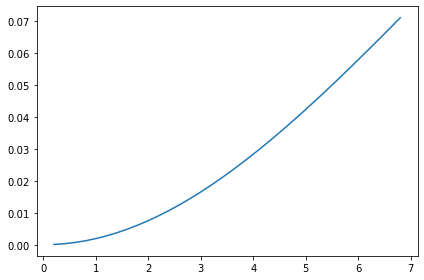

In [133]:
E_total = np.array(Power)*t
E_Drag = np.array(Drag)*t
drag_ratio = 1 - (E_total-E_Drag)/(E_total) 
plt.plot(V, drag_ratio)

In [158]:
def calculate_distance(df):
    df = df.reset_index()
    d = 0
    for i in range(len(df)-1):
        coords_2 = (df.position_y[i], df.position_x[i])
        coords_1 = (df.position_y[i+1], df.position_x[i+1])
        d += geopy.distance.geodesic(coords_1, coords_2).km
    return d

In [160]:
B = data[data.route=="B"].copy()
tests = list(set(B.test))


D = []
E = []
T = []
S = []
P = []


for test in tests:
    df = B[B.test==test].copy()
    e_real = scipy.integrate.simps(y=df.power, x=df["time"], even="avg") / 3600
    E.append(e_real)
    D.append(calculate_distance(df))
    T.append(df.time.max()-df.time.min())
    S.append(df.speed.min())
    P.append(df.payload.min())
    
    

In [163]:
summary_B = pd.DataFrame({"test": tests, "energy":E, "distance":D,"duration":T, 'speed':S, 'payload':P})
summary_B['e_km'] = summary_B.energy/summary_B.distance

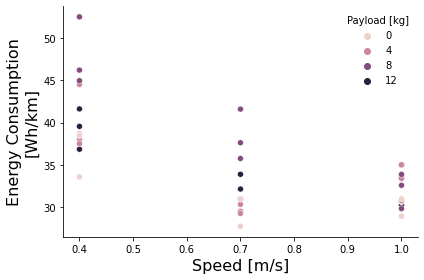

In [175]:
sns.scatterplot(x='speed', y='e_km', hue='payload', data=summary_B)
plt.ylabel("Energy Consumption\n[Wh/km]", fontsize=16)
plt.xlabel("Speed [m/s]", fontsize=16)
plt.legend(title="Payload [kg]", frameon=False)
sns.despine(top=True, right=True)
plt.show()

In [179]:
e_04 = summary_B.loc[summary_B.speed==0.4,'e_km']
e_07 = summary_B.loc[summary_B.speed==0.7,'e_km']
e_10 = summary_B.loc[summary_B.speed==1.0,'e_km']

In [180]:
print(e_04.mean(), e_07.mean(), e_10.mean(), e_04.std(), e_07.std(), e_10.std())

41.0446485034921 32.70110522691979 32.06161051678436 5.183795184526511 4.1598924082735795 2.079375011199845
